In [1]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "TrainSet0507_NoDuplicatesHV.xlsx" #TrainSet0507_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [2]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (934, 19)

컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'Unnamed: 9', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
   Material HeatTreatment      E   YS     TS    EL   RA      K      n  \
0   0.6040           NaN  140.0  420  570.0   NaN  NaN  902.0  0.130   
1   0.7040           NaN  165.0  323  470.0  17.3  NaN  514.0  0.076   
2   0.7060           NaN  158.0  382  632.0     7  NaN  507.0  0.043   
3   0.7060           NaN  175.0  480  738.0   4.4  NaN    NaN    NaN   
4   0.8155           NaN  155.0  389  600.0     5  NaN  582.0  0.073   

   Unnamed: 9   HB  sy     np    Kp   sf      b      ef      c  \
0         NaN  NaN NaN  0.153  1012  646 -0.078  0.0353 -0.451   
1         NaN  NaN NaN  0.065   677  851 -0.075  9.7123 -1.016   
2         NaN  NaN NaN  0.076   750  720 -0.058  0.7236 -0.782   
3         NaN  NaN NaN  0.103   936  805 -0.067  0.2314 -0.652   
4         NaN  NaN NaN  0.128   911  712 -0.073  0.14

In [3]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")


사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'sf', 'b', 'ef', 'c']
경고: 다음 컬럼이 데이터에 없습니다: ['HV']. 해당 컬럼 없이 진행합니다.

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa       17
YS_MPa      40
TS_MPa      29
HB         259
spf_MPa     12
b            5
epf         13
c            9
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 16개 행을 삭제했습니다.
남은 행: 918


In [4]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 단순 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 변환 (필요수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

HV column not found. Skipping HV->HB conversion.

'HB_processed' 컬럼을 특성에 추가했습니다.

Dropped 252 rows where both HB and HV were missing or invalid.
Dropped 17 rows with missing values in features: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed'].

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame after HB/HV processing and final NA drop:
       E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b    epf      c
75  207000.0   225.0   321.0          86.0    829.0 -0.129  0.246 -0.492
76  207000.0   236.0   356.0          86.0    832.0 -0.122  0.450 -0.534
77  207000.0   245.0   323.0          86.0    872.0 -0.134  0.271 -0.503
78  207000.0   267.0   359.0          86.0    483.0 -0.079  0.215 -0.450
79  200000.0   400.0   414.0         125.0    538.0 -0.073  0.110 -0.410

Missing values check for final features and targets:
E_MPa           0
YS_MPa          0
TS_MPa          0
HB_processed    0
spf_MPa         0
b        


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa  HB_processed      spf_MPa  \
count     649.000000   649.000000   649.000000    649.000000   649.000000   
mean   204452.146379   757.098767   996.980863    274.012789  1475.974669   
std      9026.775641   443.600834   449.653623    113.667830   630.950800   
min    172000.000000   190.000000   318.000000     80.000000   391.000000   
25%    200000.000000   430.000000   682.000000    193.000000  1055.000000   
50%    206000.000000   644.000000   910.000000    255.000000  1274.000000   
75%    210000.000000   953.000000  1174.000000    327.000000  1780.000000   
max    249000.000000  2536.000000  2950.000000    670.000000  5813.000000   

                b         epf           c  
count  649.000000  649.000000  649.000000  
mean    -0.094427    0.848022   -0.608301  
std      0.029661    1.480783    0.136126  
min     -0.253000    0.000570   -1.082000  
25%

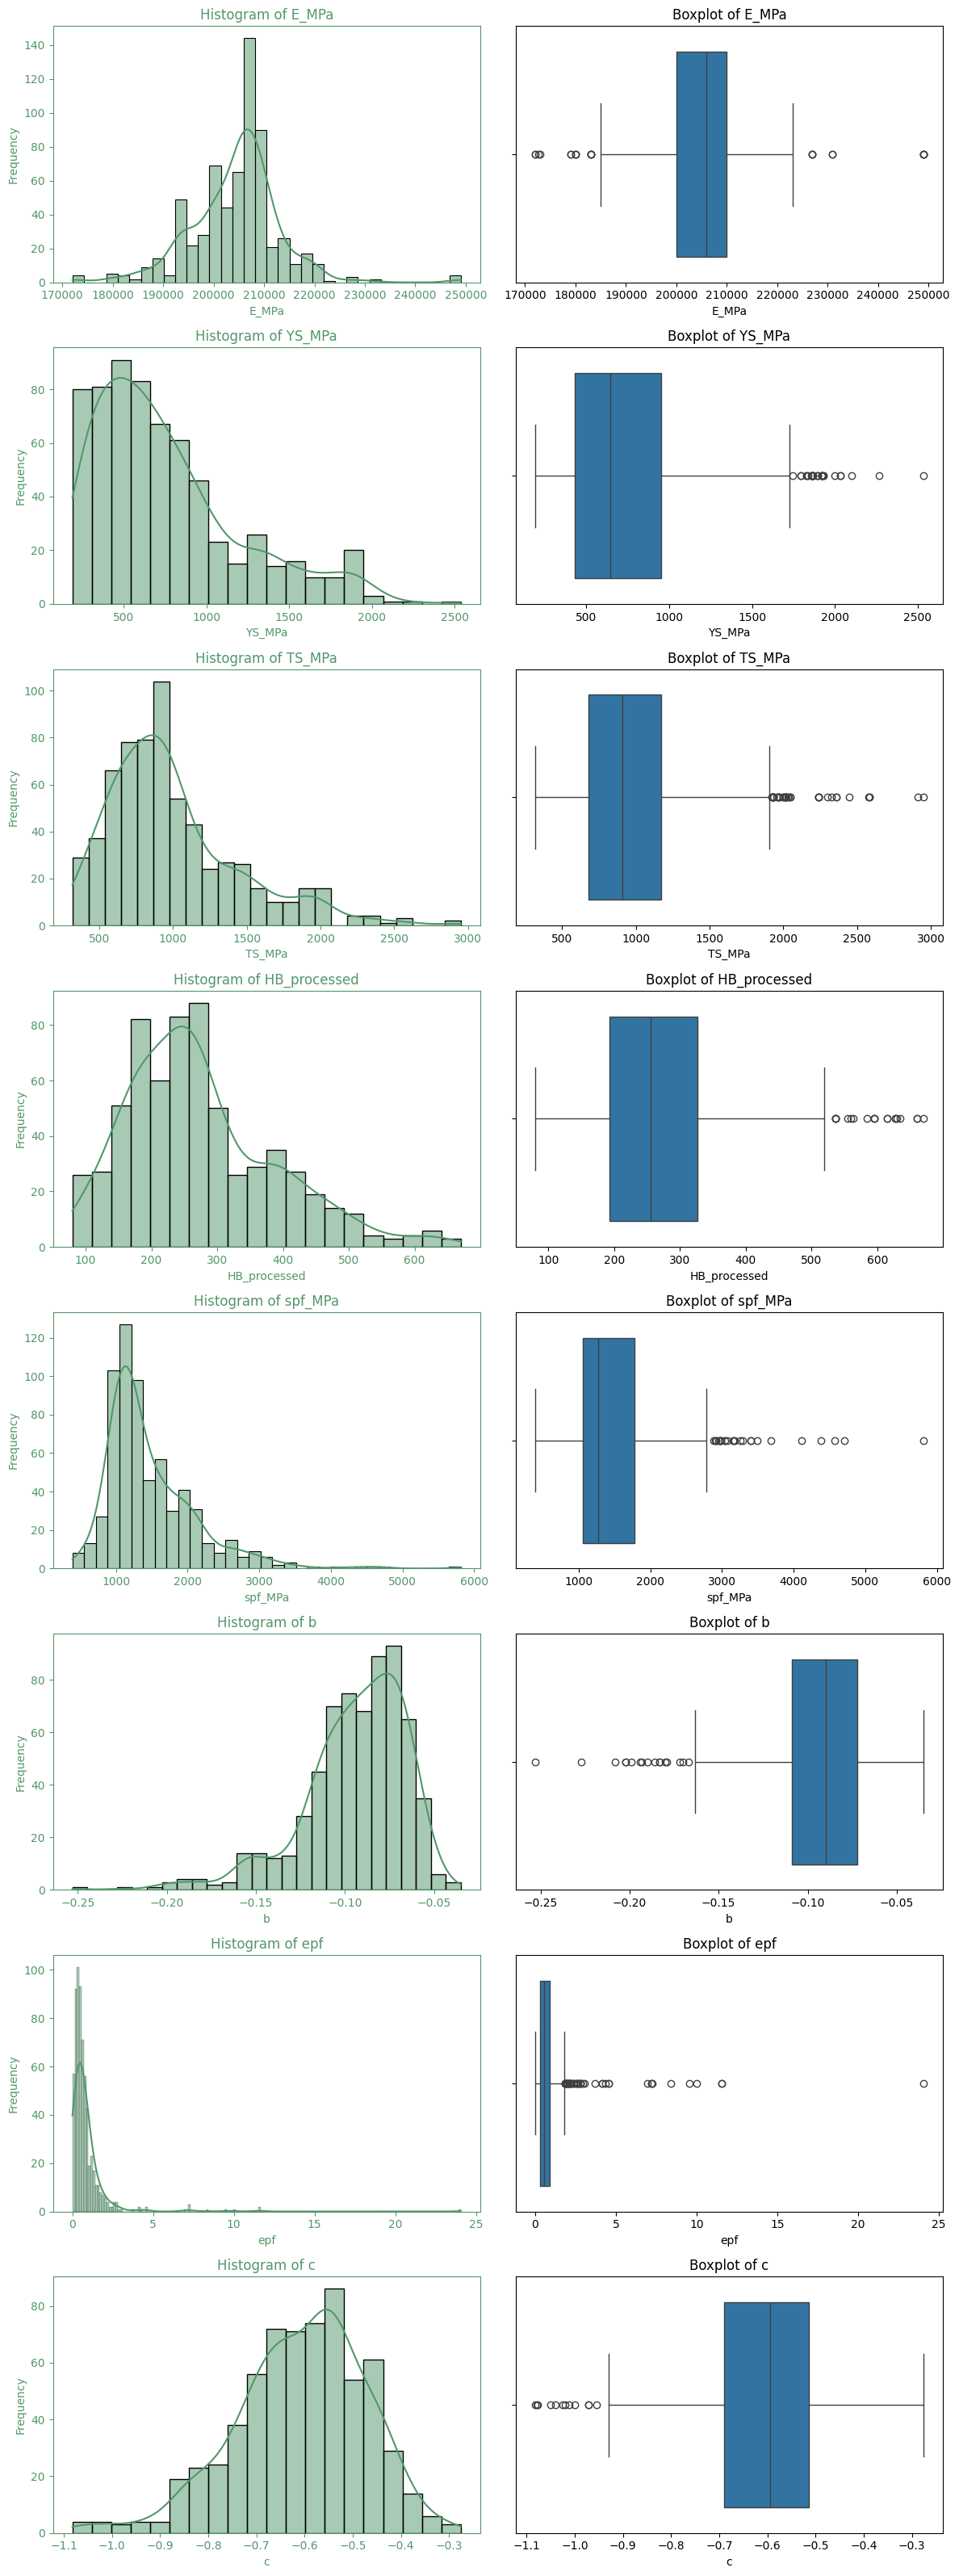

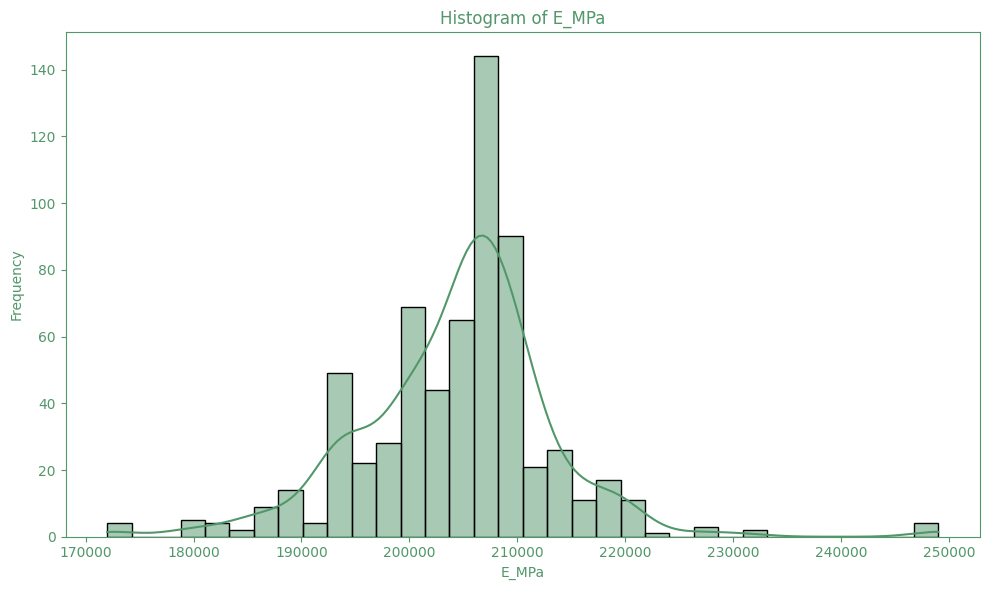


Calculating and Plotting Correlation Matrix...


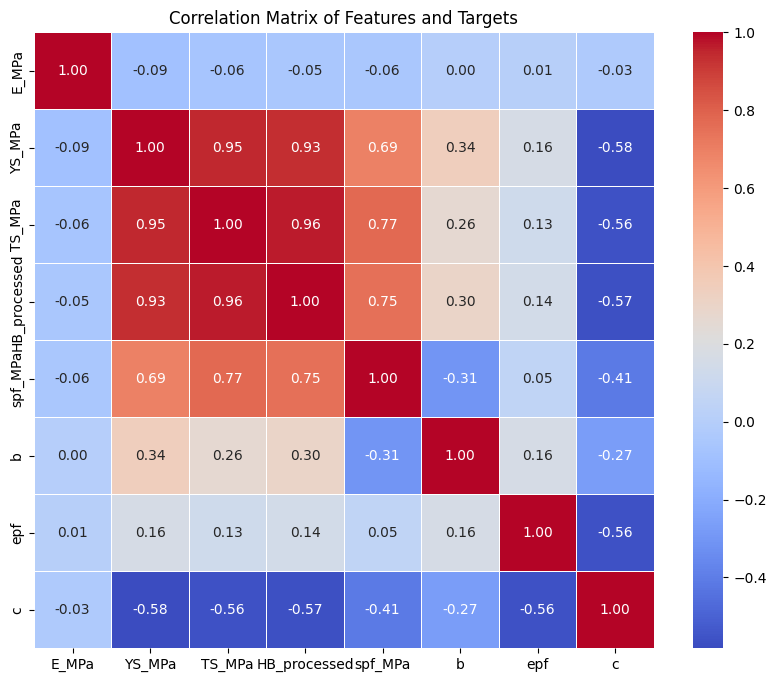


Analysis of target parameters:
Range of 'b': -0.253 -0.035
Range of 'c': -1.082 -0.276
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 1.54%

--- Analysis of Log-Transformed epf ---

Descriptive Statistics (Log-Transformed epf):
count    649.000000
mean       0.506565
std        0.384387
min        0.000570
25%        0.263133
50%        0.425268
75%        0.647627
max        3.220834
Name: epf, dtype: float64


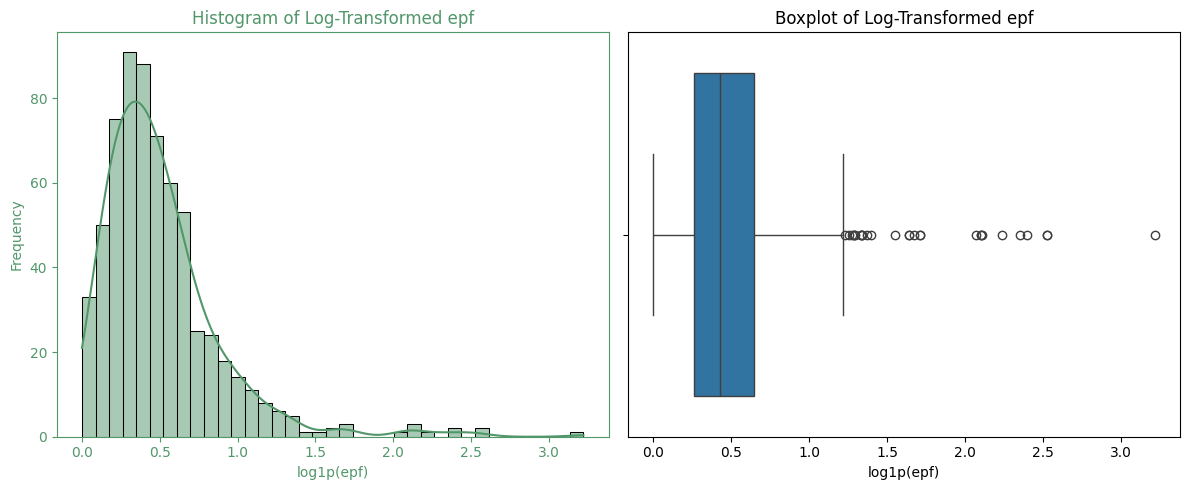

In [5]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height), facecolor='none')

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])
        
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             # 1열(히스토그램)에 custom color 적용
             sns.histplot(df[col], kde=True, ax=axes[i, 0], color=custom_color)
             axes[i, 0].set_title(f'Histogram of {col}', color=custom_color)
             axes[i, 0].set_xlabel(col, color=custom_color)
             axes[i, 0].set_ylabel('Frequency', color=custom_color)
             axes[i, 0].tick_params(axis='x', colors=custom_color)
             axes[i, 0].tick_params(axis='y', colors=custom_color)
             axes[i, 0].spines['bottom'].set_color(custom_color)
             axes[i, 0].spines['top'].set_color(custom_color)
             axes[i, 0].spines['left'].set_color(custom_color)
             axes[i, 0].spines['right'].set_color(custom_color)
             axes[i, 0].set_facecolor('none')  # 배경 투명하게 설정
             
             # 2열(박스플롯)은 기본 색상 유지
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')
             axes[i, 1].set_facecolor('none')  # 배경 투명하게 설정

    plt.tight_layout()
    plt.show()
    
    # custom color 그래프 추가 (첫 번째 컬럼만)
    if len(feature_cols) > 0:
        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        first_col = feature_cols[0]
        
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # 배경 투명하게 설정
        sns.histplot(df[first_col], kde=True, ax=ax, color=custom_color)
        
        # 모든 요소를 custom color로 설정
        ax.set_title(f'Histogram of {first_col}', color=custom_color)
        ax.set_xlabel(first_col, color=custom_color)
        ax.set_ylabel('Frequency', color=custom_color)
        ax.tick_params(axis='x', colors=custom_color)
        ax.tick_params(axis='y', colors=custom_color)
        ax.spines['bottom'].set_color(custom_color)
        ax.spines['top'].set_color(custom_color)
        ax.spines['left'].set_color(custom_color)
        ax.spines['right'].set_color(custom_color)
        ax.set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)
    
    print("\n--- Analysis of Log-Transformed epf ---")
    if 'epf' in target_cols:
        epf_original_values = df['epf'].copy() # 원본 epf 값 사용 (결측치 제거 후)
        epf_log_transformed = np.log1p(np.maximum(epf_original_values, 1e-10))

        print("\nDescriptive Statistics (Log-Transformed epf):")
        print(pd.Series(epf_log_transformed).describe())

        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        fig, axes = plt.subplots(1, 2, figsize=(12, 5), facecolor='none')
        
        # 히스토그램에 custom color 적용
        sns.histplot(epf_log_transformed, kde=True, ax=axes[0], color=custom_color)
        axes[0].set_title('Histogram of Log-Transformed epf', color=custom_color)
        axes[0].set_xlabel('log1p(epf)', color=custom_color)
        axes[0].set_ylabel('Frequency', color=custom_color)
        axes[0].tick_params(axis='x', colors=custom_color)
        axes[0].tick_params(axis='y', colors=custom_color)
        axes[0].spines['bottom'].set_color(custom_color)
        axes[0].spines['top'].set_color(custom_color)
        axes[0].spines['left'].set_color(custom_color)
        axes[0].spines['right'].set_color(custom_color)
        axes[0].set_facecolor('none')  # 배경 투명하게 설정

        # 박스플롯은 기본 색상 유지
        sns.boxplot(x=epf_log_transformed, ax=axes[1])
        axes[1].set_title('Boxplot of Log-Transformed epf')
        axes[1].set_xlabel('log1p(epf)')
        axes[1].set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()
    else:
        print("epf column not found in target_cols for log-transformed analysis.")

else:
    print("\nNo data available for EDA after preprocessing.")


In [6]:
# Cell 6: TS 분류 기반 데이터 준비 및 개별 학습 (수정됨)

print("\n--- TS Classification-based Data Preparation for PyTorch ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    # E_MPa 컬럼이 있는지 확인 후 추출
    if 'E_MPa' in df.columns:
        E_for_loss = df['E_MPa'].values
        print(f"E for loss shape: {E_for_loss.shape}")
    else:
        print("Warning: E_MPa column not found. Cannot extract E for physics loss calculation.")
        E_for_loss = np.zeros(len(df)) # 임시값 또는 다른 처리 필요

    # TS 값 추출 (분류 기준)
    ts_values = df['TS_MPa'].values
    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")
    print(f"TS values shape: {ts_values.shape}")

    # === TS 기준으로 데이터 분류 ===
    # Low group: TS < 750, Mid group: 750 <= TS < 1030, High group: TS >= 1030
    low_mask = ts_values < 750
    mid_mask = (ts_values >= 750) & (ts_values < 1030)
    high_mask = ts_values >= 1030
    
    print(f"\n--- TS 기준 데이터 분류 결과 ---")
    print(f"Low group (TS < 750): {np.sum(low_mask)}개 샘플")
    print(f"Mid group (750 <= TS < 1030): {np.sum(mid_mask)}개 샘플") 
    print(f"High group (TS >= 1030): {np.sum(high_mask)}개 샘플")
    print(f"총 샘플 수: {len(ts_values)}개")
    
    # 각 그룹별 데이터 분리
    groups = {
        'lowTS': {'mask': low_mask, 'name': 'Low TS (<750)'},
        'midTS': {'mask': mid_mask, 'name': 'Mid TS (750-1030)'},
        'highTS': {'mask': high_mask, 'name': 'High TS (>=1030)'}
    }
    
    # 각 그룹별로 개별 처리
    for group_name, group_info in groups.items():
        mask = group_info['mask']
        group_display_name = group_info['name']
        
        if np.sum(mask) == 0:
            print(f"\n{group_display_name} 그룹에 데이터가 없어 건너뜁니다.")
            continue
            
        print(f"\n=== {group_display_name} 그룹 처리 시작 ===")
        
        # 그룹 데이터 추출
        X_group = X[mask]
        y_group = y[mask] 
        E_group = E_for_loss[mask]
        
        print(f"그룹 데이터 크기: X={X_group.shape}, y={y_group.shape}, E={E_group.shape}")
        
        # 최소 샘플 수 확인 (train/val/test 분할을 위해)
        if len(X_group) < 10:
            print(f"경고: {group_display_name} 그룹의 샘플 수가 너무 적습니다 ({len(X_group)}개). 건너뜁니다.")
            continue
            
        # 1. Train-Validation-Test Split (그룹별)
        X_train_val_g, X_test_g, y_train_val_g, y_test_g, E_train_val_g, E_test_g = train_test_split(
            X_group, y_group, E_group, test_size=0.15, random_state=seed)
        X_train_g, X_val_g, y_train_g, y_val_g, E_train_g, E_val_g = train_test_split(
            X_train_val_g, y_train_val_g, E_train_val_g, test_size=0.1765, random_state=seed)

        print(f"{group_display_name} - Train: {X_train_g.shape[0]}, Val: {X_val_g.shape[0]}, Test: {X_test_g.shape[0]}")

        # 2. Feature Scaling (그룹별)
        scaler_X_group = StandardScaler()
        X_train_g_scaled = scaler_X_group.fit_transform(X_train_g)
        X_val_g_scaled = scaler_X_group.transform(X_val_g)
        X_test_g_scaled = scaler_X_group.transform(X_test_g)
        
        # Feature scaler 저장
        joblib.dump(scaler_X_group, f'scaler_X_{group_name}.pkl')
        print(f"Feature scaler 저장됨: scaler_X_{group_name}.pkl")

        # 3. Target 변환 및 스케일링 (그룹별)
        target_cols_idx = {name: idx for idx, name in enumerate(target_cols)}
        epf_idx = target_cols_idx.get('epf', -1)

        y_train_g_transformed = y_train_g.copy()
        y_val_g_transformed = y_val_g.copy()
        y_test_g_transformed = y_test_g.copy()

        # epf 로그 변환 (그룹별)
        if epf_idx != -1:
            print(f"{group_display_name} - epf 컬럼에 로그 변환 적용")
            y_train_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_train_g_transformed[:, epf_idx], 1e-10))
            y_val_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_val_g_transformed[:, epf_idx], 1e-10))
            y_test_g_transformed[:, epf_idx] = np.log1p(np.maximum(y_test_g_transformed[:, epf_idx], 1e-10))

        # 타겟별 개별 스케일링 (그룹별)
        scalers_y_group = {}
        y_train_g_scaled = np.zeros_like(y_train_g_transformed)
        y_val_g_scaled = np.zeros_like(y_val_g_transformed)
        y_test_g_scaled = np.zeros_like(y_test_g_transformed)

        for i, col_name in enumerate(target_cols):
            scalers_y_group[col_name] = StandardScaler()
            scalers_y_group[col_name].fit(y_train_g_transformed[:, i].reshape(-1, 1))
            
            y_train_g_scaled[:, i] = scalers_y_group[col_name].transform(y_train_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_val_g_scaled[:, i] = scalers_y_group[col_name].transform(y_val_g_transformed[:, i].reshape(-1, 1)).flatten()
            y_test_g_scaled[:, i] = scalers_y_group[col_name].transform(y_test_g_transformed[:, i].reshape(-1, 1)).flatten()

        # Target scaler와 target_cols 정보 함께 저장
        data_to_save_y_group = {'scalers': scalers_y_group, 'target_cols': target_cols}
        joblib.dump(data_to_save_y_group, f'scaler_y_{group_name}.pkl')
        print(f"Target scaler 저장됨: scaler_y_{group_name}.pkl (target_cols 포함)")

        # 4. PyTorch 데이터 로더 생성 (그룹별)
        batch_size = min(32, len(X_train_g) // 4)  # 그룹 크기에 따라 배치 크기 조정
        
        train_dataset_g = TensorDataset(
            torch.tensor(X_train_g_scaled, dtype=torch.float32),
            torch.tensor(y_train_g_scaled, dtype=torch.float32),
            torch.tensor(E_train_g, dtype=torch.float32)
        )
        val_dataset_g = TensorDataset(
            torch.tensor(X_val_g_scaled, dtype=torch.float32),
            torch.tensor(y_val_g_scaled, dtype=torch.float32),
            torch.tensor(E_val_g, dtype=torch.float32)
        )
        test_dataset_g = TensorDataset(
            torch.tensor(X_test_g_scaled, dtype=torch.float32),
            torch.tensor(y_test_g_scaled, dtype=torch.float32),
            torch.tensor(E_test_g, dtype=torch.float32)
        )

        train_loader_g = DataLoader(train_dataset_g, batch_size=batch_size, shuffle=True)
        val_loader_g = DataLoader(val_dataset_g, batch_size=batch_size, shuffle=False)
        test_loader_g = DataLoader(test_dataset_g, batch_size=batch_size, shuffle=False)
        
        print(f"{group_display_name} - 데이터 로더 생성 완료 (배치 크기: {batch_size})")
        
        # 그룹별 변수를 글로벌 네임스페이스에 저장
        globals()[f'X_train_{group_name}'] = X_train_g
        globals()[f'X_val_{group_name}'] = X_val_g  
        globals()[f'X_test_{group_name}'] = X_test_g
        globals()[f'y_train_{group_name}'] = y_train_g
        globals()[f'y_val_{group_name}'] = y_val_g
        globals()[f'y_test_{group_name}'] = y_test_g
        globals()[f'E_train_{group_name}'] = E_train_g
        globals()[f'E_val_{group_name}'] = E_val_g
        globals()[f'E_test_{group_name}'] = E_test_g
        
        globals()[f'X_train_{group_name}_scaled'] = X_train_g_scaled
        globals()[f'X_val_{group_name}_scaled'] = X_val_g_scaled
        globals()[f'X_test_{group_name}_scaled'] = X_test_g_scaled
        globals()[f'y_train_{group_name}_scaled'] = y_train_g_scaled
        globals()[f'y_val_{group_name}_scaled'] = y_val_g_scaled
        globals()[f'y_test_{group_name}_scaled'] = y_test_g_scaled
        
        globals()[f'scaler_X_{group_name}'] = scaler_X_group
        globals()[f'scalers_y_{group_name}'] = scalers_y_group
        globals()[f'train_loader_{group_name}'] = train_loader_g
        globals()[f'val_loader_{group_name}'] = val_loader_g
        globals()[f'test_loader_{group_name}'] = test_loader_g
        
        print(f"{group_display_name} - 모든 변수 저장 완료")

    print("\n=== 모든 그룹 데이터 준비 완료 ===")
    print("저장된 스케일러 파일:")
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'scaler_X_{group_name}' in globals():
            print(f"  - scaler_X_{group_name}.pkl")
            print(f"  - scaler_y_{group_name}.pkl")

else:
    print("DataFrame이 비어있어 데이터 준비를 건너뜁니다.")



--- TS Classification-based Data Preparation for PyTorch ---
E for loss shape: (649,)
Features shape (X): (649, 4)
Targets shape (y): (649, 4)
TS values shape: (649,)

--- TS 기준 데이터 분류 결과 ---
Low group (TS < 750): 208개 샘플
Mid group (750 <= TS < 1030): 215개 샘플
High group (TS >= 1030): 226개 샘플
총 샘플 수: 649개

=== Low TS (<750) 그룹 처리 시작 ===
그룹 데이터 크기: X=(208, 4), y=(208, 4), E=(208,)
Low TS (<750) - Train: 144, Val: 32, Test: 32
Feature scaler 저장됨: scaler_X_lowTS.pkl
Low TS (<750) - epf 컬럼에 로그 변환 적용
Target scaler 저장됨: scaler_y_lowTS.pkl (target_cols 포함)
Low TS (<750) - 데이터 로더 생성 완료 (배치 크기: 32)
Low TS (<750) - 모든 변수 저장 완료

=== Mid TS (750-1030) 그룹 처리 시작 ===
그룹 데이터 크기: X=(215, 4), y=(215, 4), E=(215,)
Mid TS (750-1030) - Train: 149, Val: 33, Test: 33
Feature scaler 저장됨: scaler_X_midTS.pkl
Mid TS (750-1030) - epf 컬럼에 로그 변환 적용
Target scaler 저장됨: scaler_y_midTS.pkl (target_cols 포함)
Mid TS (750-1030) - 데이터 로더 생성 완료 (배치 크기: 32)
Mid TS (750-1030) - 모든 변수 저장 완료

=== High TS (>=1030) 그룹 처리 시작 ===
그룹

In [7]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 옵투나 최적화 결과 적용 [192, 384, 352, 224] 구조

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[192, 384, 352, 224], dropout_p=0.35): 
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim

            layers = []
            last_dim = input_dim
            for hidden_dim in hidden_dims: # 인자로 받은 hidden_dims를 사용
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_p))  # 드롭아웃 레이어 추가
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4 
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4 
    
    # --- 옵투나 최적화 결과 적용 ---
    hidden_dims_target = [192, 384, 352, 224] # 옵투나 최적화 결과 (4개 층)
    dropout_rate = 0.35  # 옵투나 최적화 결과
    
    # 모델 생성 시 hidden_dims_target와 dropout_p를 전달합니다.
    model = FatiguePINN(input_dim, output_dim, hidden_dims=hidden_dims_target, dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) 

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN with hidden_dims=[192, 384, 352, 224], dropout_p=0.35):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=192, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.35, inplace=False)
    (3): Linear(in_features=192, out_features=384, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.35, inplace=False)
    (6): Linear(in_features=384, out_features=352, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.35, inplace=False)
    (9): Linear(in_features=352, out_features=224, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.35, inplace=False)
    (12): Linear(in_features=224, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([32, 4])
Dummy output shape: torch.Size([32, 4])


In [8]:
# Cell 8: 손실 함수 정의 (PINN) - lambda_physics_value 수정

if len(df) > 0:
    def pinn_loss_function(model_outputs_scaled, targets_scaled, E_unscaled,
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           lambda_physics=0.019082887574579432, num_physics_points=20, 
                           Nf_min=1e1, Nf_max=1e7, device='cpu'):
        """
        Calculates the combined Data and Physics loss for the Fatigue PINN.
        (Function definition remains the same as provided previously)
        """
        # 1. Data Loss (MSE on scaled parameters)
        data_loss_fn = nn.MSELoss()
        
        data_loss_components = []
        epf_loss_weight = 1.0458369452716008  # 옵투나 최적화 결과 적용
                             # 이 값을 조절하며 epf 정확도 변화를 관찰합니다.

        for i, col_name in enumerate(target_cols_list):
            # 각 타겟별로 MSE 손실 계산
            loss_per_target = data_loss_fn(model_outputs_scaled[:, i], targets_scaled[:, i])
            
            if col_name == 'epf':
                data_loss_components.append(epf_loss_weight * loss_per_target)
                print(f"DEBUG: epf_loss (weighted): {epf_loss_weight * loss_per_target.item():.4f}, original_epf_loss: {loss_per_target.item():.4f}") # 디버깅용
            else:
                data_loss_components.append(loss_per_target)
                # print(f"DEBUG: {col_name}_loss: {loss_per_target.item():.4f}") # 다른 타겟 디버깅용 (선택적)

        # 모든 타겟 손실 요소들의 합계를 구함
        data_loss = torch.stack(data_loss_components).sum() 
        # 또는 평균을 사용할 수도 있습니다. sum()이 더 직접적으로 epf 가중치를 반영합니다.
        # data_loss = torch.stack(data_loss_components).mean() 

        # 2. Physics Loss (Coffin-Manson)
        physics_loss = torch.tensor(0.0, device=device) # 기본값 초기화
        try:
            # Inverse transform the *predicted* parameters with our custom function
            batch_size = model_outputs_scaled.shape[0]
            
            # 예측값 역변환
            model_outputs_scaled_np = model_outputs_scaled.detach().cpu().numpy()
            model_outputs_unscaled_np = np.zeros_like(model_outputs_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                model_outputs_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(model_outputs_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                model_outputs_unscaled_np[:, epf_idx_dynamic] = np.expm1(model_outputs_unscaled_np[:, epf_idx_dynamic])

            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)

            # 동적 인덱스 추출
            spf_pred_idx = target_cols_list.index('spf_MPa')
            b_pred_idx = target_cols_list.index('b')
            epf_pred_idx = target_cols_list.index('epf')
            c_pred_idx = target_cols_list.index('c')

            spf_pred = model_outputs_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_pred = model_outputs_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_pred = model_outputs_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_pred = model_outputs_unscaled[:, c_pred_idx].unsqueeze(1)

            reversals = torch.logspace(torch.log10(torch.tensor(Nf_min)), torch.log10(torch.tensor(Nf_max)), num_physics_points).unsqueeze(0).to(device)

            # Avoid division by zero or invalid E
            E_unscaled_safe = torch.where(E_unscaled <= 0, torch.tensor(1e-6, device=device), E_unscaled)

            epsilon_a_pred = (spf_pred / E_unscaled_safe) * (reversals ** b_pred) + epf_pred * (reversals ** c_pred)

            # 실제값 역변환
            targets_scaled_np = targets_scaled.detach().cpu().numpy()
            targets_unscaled_np = np.zeros_like(targets_scaled_np)

            for i, col_name in enumerate(target_cols_list):
                targets_unscaled_np[:, i] = scalers_y_dict[col_name].inverse_transform(targets_scaled_np[:, i].reshape(-1, 1)).flatten()

            if 'epf' in target_cols_list:
                epf_idx_dynamic = target_cols_list.index('epf')
                targets_unscaled_np[:, epf_idx_dynamic] = np.expm1(targets_unscaled_np[:, epf_idx_dynamic])

            targets_unscaled = torch.tensor(targets_unscaled_np, dtype=torch.float32).to(device)
            
            spf_true = targets_unscaled[:, spf_pred_idx].unsqueeze(1)
            b_true = targets_unscaled[:, b_pred_idx].unsqueeze(1)
            epf_true = targets_unscaled[:, epf_pred_idx].unsqueeze(1)
            c_true = targets_unscaled[:, c_pred_idx].unsqueeze(1)
            
            epsilon_a_true = (spf_true / E_unscaled_safe) * (reversals ** b_true) + epf_true * (reversals ** c_true)

            physics_loss = torch.mean((epsilon_a_pred - epsilon_a_true)**2)

            # Handle potential NaN in physics loss (e.g., from large exponents)
            if torch.isnan(physics_loss):
                 physics_loss = torch.tensor(0.0, device=device)

        except KeyError as e:
            print(f"Warning: KeyError in physics loss calculation: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)
        except Exception as e:
            print(f"Warning: Error calculating physics loss: {e}. Setting physics loss to 0 for this batch.")
            physics_loss = torch.tensor(0.0, device=device)


        # 3. Total Loss
        total_loss = data_loss + lambda_physics * physics_loss

        return total_loss, data_loss, physics_loss

    # --- Test the loss function ---
    try:
        sample_X, sample_y_scaled, sample_E = next(iter(train_loader))
        sample_X, sample_y_scaled, sample_E = sample_X.to(device), sample_y_scaled.to(device), sample_E.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        # --- 옵투나 최적화 결과 적용 ---
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        
        total_loss, data_loss, physics_loss = pinn_loss_function(
            sample_output_scaled, sample_y_scaled, sample_E, 
            scalers_y, target_cols,  # 수정된 부분
            lambda_physics=lambda_physics_value, device=device
        )

        print(f"\nTesting Loss Function (lambda_physics = {lambda_physics_value}):") # 변경된 값 출력
        print(f"  Sample Output (scaled) shape: {sample_output_scaled.shape}")
        print(f"  Sample Target (scaled) shape: {sample_y_scaled.shape}")
        print(f"  Sample E (unscaled) shape: {sample_E.shape}")
        print(f"  Calculated Total Loss: {total_loss.item():.4f}")
        print(f"  Calculated Data Loss: {data_loss.item():.4f}")
        print(f"  Calculated Physics Loss: {physics_loss.item():.4f}") # 이 값은 lambda_physics가 곱해지기 전의 값입니다.
        print(f"  Weighted Physics Loss (in Total Loss): {(lambda_physics_value * physics_loss.item()):.4f}")

    except StopIteration:
        print(f"\n데이터 로더가 비어 있어 손실 함수를 테스트할 수 없습니다.")
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        print(f"기본값 lambda_physics_value = {lambda_physics_value}를 사용합니다.")
    except Exception as e:
        print(f"\nCould not test loss function, likely due to data loader issue: {e}")
        # --- 옵투나 최적화 결과 적용 ---
        lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
        print(f"Using default lambda_physics_value = {lambda_physics_value}")


else:
    print("\nSkipping loss function definition and testing.")
    # --- 옵투나 최적화 결과 적용 ---
    lambda_physics_value = 0.019082887574579432 # 옵투나 최적화 결과
    print(f"Using default lambda_physics_value = {lambda_physics_value} as no data is available.")


Could not test loss function, likely due to data loader issue: name 'train_loader' is not defined
Using default lambda_physics_value = 0.019082887574579432



=== 그룹별 개별 모델 학습 시작 ===
하이퍼파라미터: 에폭=200, 학습률=0.001457, Lambda_Physics=0.019083, 조기종료 인내=20

=== 디버깅: 그룹별 데이터 로더 존재 확인 ===
lowTS 그룹:
  - train_loader_lowTS: 존재
  - val_loader_lowTS: 존재
  - scalers_y_lowTS: 존재
  - 학습 배치 수: 5
midTS 그룹:
  - train_loader_midTS: 존재
  - val_loader_midTS: 존재
  - scalers_y_midTS: 존재
  - 학습 배치 수: 5
highTS 그룹:
  - train_loader_highTS: 존재
  - val_loader_highTS: 존재
  - scalers_y_highTS: 존재
  - 학습 배치 수: 5


=== lowTS 그룹 모델 학습 시작 ===
lowTS 그룹 모델 생성 완료: 입력 크기=4, 출력 크기=4
DEBUG: epf_loss (weighted): 1.0953, original_epf_loss: 1.0473
DEBUG: epf_loss (weighted): 0.8204, original_epf_loss: 0.7844
DEBUG: epf_loss (weighted): 1.9172, original_epf_loss: 1.8332
DEBUG: epf_loss (weighted): 0.5889, original_epf_loss: 0.5630
DEBUG: epf_loss (weighted): 0.6202, original_epf_loss: 0.5930
DEBUG: epf_loss (weighted): 1.4111, original_epf_loss: 1.3492
lowTS - 에폭 [1/200], 학습 손실: 3.8526 (데이터: 3.8526, 물리: 0.0000), 검증 손실: 3.8641 (데이터: 3.8641, 물리: 0.0000)
  lowTS - 검증 손실 개선, 모델 저장됨
DEBUG:

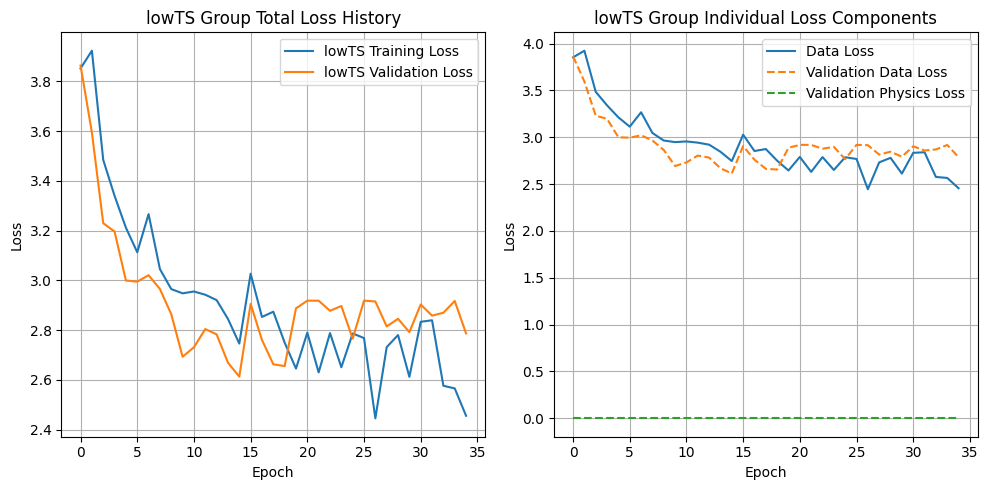


=== midTS 그룹 모델 학습 시작 ===
midTS 그룹 모델 생성 완료: 입력 크기=4, 출력 크기=4
DEBUG: epf_loss (weighted): 0.7490, original_epf_loss: 0.7161
DEBUG: epf_loss (weighted): 0.7319, original_epf_loss: 0.6998
DEBUG: epf_loss (weighted): 2.1565, original_epf_loss: 2.0619
DEBUG: epf_loss (weighted): 0.6862, original_epf_loss: 0.6561
DEBUG: epf_loss (weighted): 0.7074, original_epf_loss: 0.6764
DEBUG: epf_loss (weighted): 1.0276, original_epf_loss: 0.9826
DEBUG: epf_loss (weighted): 0.0448, original_epf_loss: 0.0429
midTS - 에폭 [1/200], 학습 손실: 3.9716 (데이터: 3.9716, 물리: 0.0000), 검증 손실: 2.5884 (데이터: 2.5884, 물리: 0.0000)
  midTS - 검증 손실 개선, 모델 저장됨
DEBUG: epf_loss (weighted): 0.8671, original_epf_loss: 0.8291
DEBUG: epf_loss (weighted): 2.2170, original_epf_loss: 2.1198
DEBUG: epf_loss (weighted): 0.6029, original_epf_loss: 0.5765
DEBUG: epf_loss (weighted): 0.6173, original_epf_loss: 0.5902
DEBUG: epf_loss (weighted): 0.5757, original_epf_loss: 0.5505
DEBUG: epf_loss (weighted): 1.0366, original_epf_loss: 0.9912
DEB

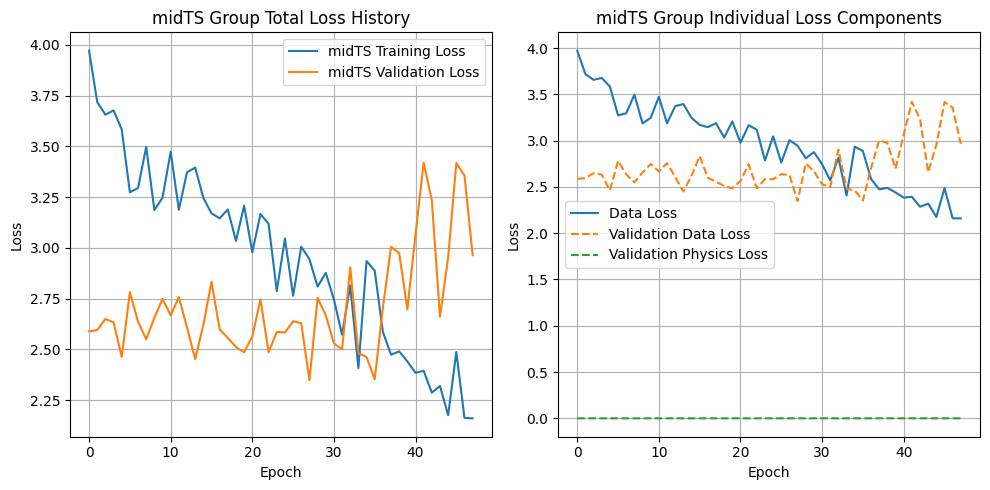


=== highTS 그룹 모델 학습 시작 ===
highTS 그룹 모델 생성 완료: 입력 크기=4, 출력 크기=4
DEBUG: epf_loss (weighted): 2.1662, original_epf_loss: 2.0712
DEBUG: epf_loss (weighted): 1.1120, original_epf_loss: 1.0633
DEBUG: epf_loss (weighted): 0.5692, original_epf_loss: 0.5442
DEBUG: epf_loss (weighted): 0.3819, original_epf_loss: 0.3652
DEBUG: epf_loss (weighted): 0.9292, original_epf_loss: 0.8885
DEBUG: epf_loss (weighted): 1.4714, original_epf_loss: 1.4069
DEBUG: epf_loss (weighted): 0.7186, original_epf_loss: 0.6871
highTS - 에폭 [1/200], 학습 손실: 4.0218 (데이터: 4.0218, 물리: 0.0000), 검증 손실: 5.8490 (데이터: 5.8490, 물리: 0.0000)
  highTS - 검증 손실 개선, 모델 저장됨
DEBUG: epf_loss (weighted): 0.4637, original_epf_loss: 0.4433
DEBUG: epf_loss (weighted): 1.1737, original_epf_loss: 1.1223
DEBUG: epf_loss (weighted): 0.8278, original_epf_loss: 0.7915
DEBUG: epf_loss (weighted): 1.2518, original_epf_loss: 1.1969
DEBUG: epf_loss (weighted): 1.1203, original_epf_loss: 1.0712
DEBUG: epf_loss (weighted): 1.6538, original_epf_loss: 1.5813

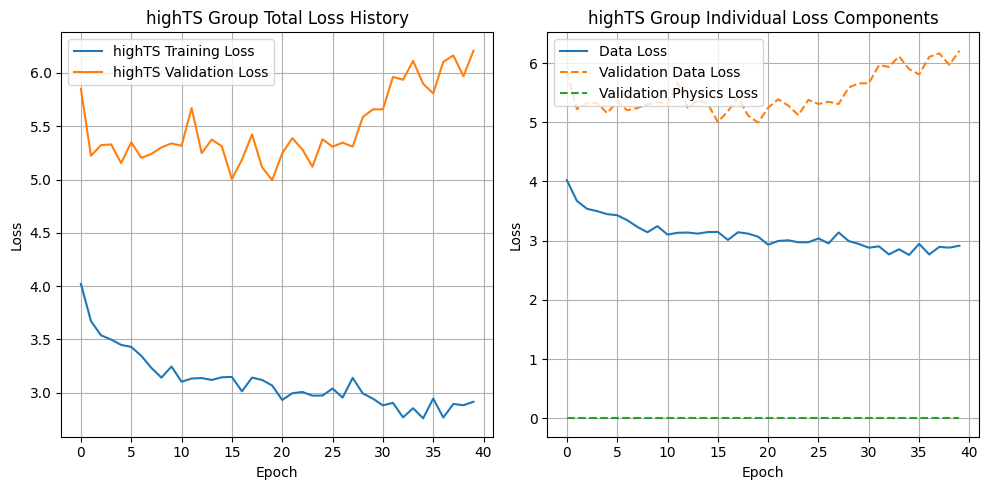


=== 모든 그룹의 모델 학습 완료 ===
저장된 모델 파일:
  - model_lowTS.pth
  - model_midTS.pth
  - model_highTS.pth

총 3개 그룹 학습 완료: ['lowTS', 'midTS', 'highTS']


In [9]:
# Cell 9: 그룹별 개별 모델 학습 (수정됨)

# 하이퍼파라미터 설정 (Optuna 최적화 결과)
learning_rate = 0.0014568233546356163
epochs = 200
patience = 20
lambda_physics_value = 0.019082887574579432

print(f"\n=== 그룹별 개별 모델 학습 시작 ===")
print(f"하이퍼파라미터: 에폭={epochs}, 학습률={learning_rate:.6f}, Lambda_Physics={lambda_physics_value:.6f}, 조기종료 인내={patience}")

# 디버깅: 필요한 변수들 존재 확인
print("\n=== 디버깅: 그룹별 데이터 로더 존재 확인 ===")
for group_name in ['lowTS', 'midTS', 'highTS']:
    train_loader_var = f'train_loader_{group_name}'
    val_loader_var = f'val_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    print(f"{group_name} 그룹:")
    print(f"  - {train_loader_var}: {'존재' if train_loader_var in globals() else '없음'}")
    print(f"  - {val_loader_var}: {'존재' if val_loader_var in globals() else '없음'}")
    print(f"  - {scalers_y_var}: {'존재' if scalers_y_var in globals() else '없음'}")
    
    if train_loader_var in globals():
        print(f"  - 학습 배치 수: {len(globals()[train_loader_var])}")
print()

# 각 그룹별로 모델 학습
for group_name in ['lowTS', 'midTS', 'highTS']:
    # 해당 그룹의 데이터 로더가 존재하는지 확인
    train_loader_var = f'train_loader_{group_name}'
    val_loader_var = f'val_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    if train_loader_var not in globals() or val_loader_var not in globals():
        print(f"\n{group_name} 그룹: 데이터 로더가 없어 건너뜁니다.")
        continue
        
    train_loader_g = globals()[train_loader_var]
    val_loader_g = globals()[val_loader_var]
    scalers_y_g = globals()[scalers_y_var]
    
    print(f"\n=== {group_name} 그룹 모델 학습 시작 ===")
    
    # 그룹별 모델 생성
    model_g = FatiguePINN(
        input_dim=len(feature_cols),
        output_dim=len(target_cols),
        hidden_dims=[192, 384, 352, 224],  # 옵투나 최적화 결과 적용
        dropout_p=0.35  # 옵투나 최적화 결과 적용
    ).to(device)
    
    print(f"{group_name} 그룹 모델 생성 완료: 입력 크기={len(feature_cols)}, 출력 크기={len(target_cols)}")
    
    # Optimizer
    optimizer_g = torch.optim.Adam(model_g.parameters(), lr=learning_rate)
    
    # Early stopping parameters
    best_val_loss_g = float('inf')
    epochs_no_improve_g = 0
    
    # Loss history
    train_loss_history_g = []
    val_loss_history_g = []
    train_data_loss_hist_g = []
    train_phys_loss_hist_g = []
    val_data_loss_hist_g = []
    val_phys_loss_hist_g = []
    
    # 학습 루프
    for epoch in range(epochs):
        model_g.train()
        train_epoch_loss = 0.0
        train_epoch_data_loss = 0.0
        train_epoch_phys_loss = 0.0
        
        for batch_X, batch_y_scaled, batch_E in train_loader_g:
            batch_X, batch_y_scaled, batch_E = batch_X.to(device), batch_y_scaled.to(device), batch_E.to(device)
            
            outputs_scaled = model_g(batch_X)
            loss, data_loss, phys_loss = pinn_loss_function(
                outputs_scaled, batch_y_scaled, batch_E,
                scalers_y_g, target_cols,
                lambda_physics=lambda_physics_value, device=device
            )
            
            optimizer_g.zero_grad()
            loss.backward()
            optimizer_g.step()
            
            train_epoch_loss += loss.item()
            train_epoch_data_loss += data_loss.item()
            train_epoch_phys_loss += phys_loss.item() if not torch.isnan(phys_loss) else 0.0
        
        avg_train_loss = train_epoch_loss / len(train_loader_g)
        avg_train_data_loss = train_epoch_data_loss / len(train_loader_g)
        avg_train_phys_loss = train_epoch_phys_loss / len(train_loader_g)
        train_loss_history_g.append(avg_train_loss)
        train_data_loss_hist_g.append(avg_train_data_loss)
        train_phys_loss_hist_g.append(avg_train_phys_loss)
        
        # Validation phase
        model_g.eval()
        val_epoch_loss = 0.0
        val_epoch_data_loss = 0.0
        val_epoch_phys_loss = 0.0
        with torch.no_grad():
            for batch_X_val, batch_y_val_scaled, batch_E_val in val_loader_g:
                batch_X_val, batch_y_val_scaled, batch_E_val = batch_X_val.to(device), batch_y_val_scaled.to(device), batch_E_val.to(device)
                
                outputs_val_scaled = model_g(batch_X_val)
                val_loss, val_data_loss, val_phys_loss = pinn_loss_function(
                    outputs_val_scaled, batch_y_val_scaled, batch_E_val,
                    scalers_y_g, target_cols,
                    lambda_physics=lambda_physics_value, device=device
                )
                val_epoch_loss += val_loss.item()
                val_epoch_data_loss += val_data_loss.item()
                val_epoch_phys_loss += val_phys_loss.item() if not torch.isnan(val_phys_loss) else 0.0
        
        avg_val_loss = val_epoch_loss / len(val_loader_g)
        avg_val_data_loss = val_epoch_data_loss / len(val_loader_g)
        avg_val_phys_loss = val_epoch_phys_loss / len(val_loader_g)
        val_loss_history_g.append(avg_val_loss)
        val_data_loss_hist_g.append(avg_val_data_loss)
        val_phys_loss_hist_g.append(avg_val_phys_loss)
        
        # 진행 상황 출력 (매 20 에폭마다)
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"{group_name} - 에폭 [{epoch+1}/{epochs}], "
                  f"학습 손실: {avg_train_loss:.4f} (데이터: {avg_train_data_loss:.4f}, 물리: {avg_train_phys_loss:.4f}), "
                  f"검증 손실: {avg_val_loss:.4f} (데이터: {avg_val_data_loss:.4f}, 물리: {avg_val_phys_loss:.4f})")
        
        # Early stopping check
        if avg_val_loss < best_val_loss_g:
            best_val_loss_g = avg_val_loss
            epochs_no_improve_g = 0
            torch.save(model_g.state_dict(), f'model_{group_name}.pth')
            if (epoch + 1) % 20 == 0 or epoch == 0:
                print(f"  {group_name} - 검증 손실 개선, 모델 저장됨")
        else:
            epochs_no_improve_g += 1
        
        if epochs_no_improve_g >= patience:
            print(f"  {group_name} - {epoch+1}번째 에폭에서 조기 종료")
            break
    
    print(f"{group_name} 그룹 학습 완료 - 최종 검증 손실: {best_val_loss_g:.4f}")
    
    # 그룹별 변수 저장
    globals()[f'model_{group_name}'] = model_g
    globals()[f'train_loss_history_{group_name}'] = train_loss_history_g
    globals()[f'val_loss_history_{group_name}'] = val_loss_history_g
    
    # 손실 그래프 그리기
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history_g, label=f'{group_name} Training Loss')
    plt.plot(val_loss_history_g, label=f'{group_name} Validation Loss')
    plt.title(f'{group_name} Group Total Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_data_loss_hist_g, label='Data Loss')
    plt.plot(val_data_loss_hist_g, label='Validation Data Loss', linestyle='--')
    plt.plot(val_phys_loss_hist_g, label='Validation Physics Loss', linestyle='--')
    plt.title(f'{group_name} Group Individual Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n=== 모든 그룹의 모델 학습 완료 ===")
print("저장된 모델 파일:")
for group_name in ['lowTS', 'midTS', 'highTS']:
    if f'model_{group_name}' in globals():
        print(f"  - model_{group_name}.pth")

# 그룹별 학습 완료 확인
trained_groups = []
for group_name in ['lowTS', 'midTS', 'highTS']:
    if f'model_{group_name}' in globals():
        trained_groups.append(group_name)

if trained_groups:
    print(f"\n총 {len(trained_groups)}개 그룹 학습 완료: {trained_groups}")
else:
    print("\n경고: 어떤 그룹도 학습되지 않았습니다. Cell 6에서 데이터 준비가 제대로 되었는지 확인하세요.")

In [10]:
# Cell 10: 그룹별 모델 평가 및 결과 통합

print("\n=== 그룹별 모델 평가 시작 ===")

# inverse_transform_targets 함수 정의 (Cell 6에서 정의된 것과 동일)
def inverse_transform_targets(scaled_targets, scalers_dict, target_cols_list):
    """
    스케일링된 타겟을 원래 스케일로 역변환
    """
    unscaled = np.zeros_like(scaled_targets)
    for i, col_name in enumerate(target_cols_list):
        unscaled[:, i] = scalers_dict[col_name].inverse_transform(scaled_targets[:, i].reshape(-1, 1)).flatten()
    return unscaled

# 모든 그룹의 결과를 통합하기 위한 리스트
all_preds_orig_combined = []
all_targets_orig_combined = []
all_E_test_combined = []
group_labels_combined = []

# 각 그룹별 평가
for group_name in ['lowTS', 'midTS', 'highTS']:
    model_var = f'model_{group_name}'
    test_loader_var = f'test_loader_{group_name}'
    scalers_y_var = f'scalers_y_{group_name}'
    
    if model_var not in globals() or test_loader_var not in globals():
        print(f"\n{group_name} 그룹: 모델 또는 테스트 로더가 없어 건너뜁니다.")
        continue
    
    model_g = globals()[model_var]
    test_loader_g = globals()[test_loader_var]
    scalers_y_g = globals()[scalers_y_var]
    
    print(f"\n=== {group_name} 그룹 평가 ===")
    
    # 테스트 데이터에 대한 예측
    model_g.eval()
    all_preds_scaled_g = []
    all_targets_scaled_g = []
    all_E_test_g = []
    
    with torch.no_grad():
        for batch_X_test, batch_y_test_scaled, batch_E_test in test_loader_g:
            batch_X_test = batch_X_test.to(device)
            
            # 예측
            preds_scaled = model_g(batch_X_test)
            
            # 결과 저장
            all_preds_scaled_g.append(preds_scaled.cpu().numpy())
            all_targets_scaled_g.append(batch_y_test_scaled.numpy())
            all_E_test_g.append(batch_E_test.numpy())
    
    # 배치 결과 연결
    all_preds_scaled_g = np.concatenate(all_preds_scaled_g, axis=0)
    all_targets_scaled_g = np.concatenate(all_targets_scaled_g, axis=0)
    all_E_test_g = np.concatenate(all_E_test_g, axis=0)
    
    print(f"{group_name} - 테스트 샘플 수: {all_preds_scaled_g.shape[0]}")
    
    # 예측값 역변환 (스케일링 해제)
    all_preds_orig_g = inverse_transform_targets(all_preds_scaled_g, scalers_y_g, target_cols)
    all_targets_orig_g = inverse_transform_targets(all_targets_scaled_g, scalers_y_g, target_cols)
    
    # epf 로그 변환 해제
    epf_idx = target_cols.index('epf') if 'epf' in target_cols else -1
    if epf_idx != -1:
        all_preds_orig_g[:, epf_idx] = np.expm1(all_preds_orig_g[:, epf_idx])
        all_targets_orig_g[:, epf_idx] = np.expm1(all_targets_orig_g[:, epf_idx])
        print(f"{group_name} - epf 로그 변환 해제 완료")
    
    # 그룹별 성능 평가
    print(f"\n{group_name} 그룹 성능 평가:")
    group_r2_scores = []
    for i, param_name in enumerate(target_cols):
        pred_param = all_preds_orig_g[:, i]
        true_param = all_targets_orig_g[:, i]
        
        # R² 계산
        r2 = r2_score(true_param, pred_param)
        group_r2_scores.append(r2)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(true_param, pred_param))
        
        print(f"  {param_name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    print(f"  평균 R² = {np.mean(group_r2_scores):.4f}")
    
    # 통합 결과에 추가
    all_preds_orig_combined.append(all_preds_orig_g)
    all_targets_orig_combined.append(all_targets_orig_g)
    all_E_test_combined.append(all_E_test_g)
    group_labels_combined.extend([group_name] * len(all_preds_orig_g))
    
    # 그룹별 변수 저장
    globals()[f'all_preds_orig_{group_name}'] = all_preds_orig_g
    globals()[f'all_targets_orig_{group_name}'] = all_targets_orig_g
    globals()[f'all_E_test_{group_name}'] = all_E_test_g

# 모든 그룹 결과 통합
if all_preds_orig_combined:
    all_preds_orig_total = np.concatenate(all_preds_orig_combined, axis=0)
    all_targets_orig_total = np.concatenate(all_targets_orig_combined, axis=0)
    all_E_test_total = np.concatenate(all_E_test_combined, axis=0)
    
    print(f"\n=== 전체 통합 결과 ===")
    print(f"총 테스트 샘플 수: {all_preds_orig_total.shape[0]}")
    
    # 전체 성능 평가
    print(f"\n전체 통합 성능 평가:")
    total_r2_scores = []
    for i, param_name in enumerate(target_cols):
        pred_param = all_preds_orig_total[:, i]
        true_param = all_targets_orig_total[:, i]
        
        # R² 계산
        r2 = r2_score(true_param, pred_param)
        total_r2_scores.append(r2)
        
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(true_param, pred_param))
        
        print(f"  {param_name}: R² = {r2:.4f}, RMSE = {rmse:.4f}")
    
    print(f"  전체 평균 R² = {np.mean(total_r2_scores):.4f}")
    
    # 전체 결과 저장
    globals()['all_preds_orig'] = all_preds_orig_total
    globals()['all_targets_orig'] = all_targets_orig_total
    globals()['E_test_tensor'] = torch.tensor(all_E_test_total, dtype=torch.float32)
    globals()['group_labels'] = group_labels_combined
    
    # 기존 변수명 호환성을 위한 통합 테스트 데이터 생성
    all_X_test_combined = []
    all_X_test_scaled_combined = []
    all_y_test_combined = []
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        X_test_var = f'X_test_{group_name}'
        X_test_scaled_var = f'X_test_{group_name}_scaled'
        y_test_var = f'y_test_{group_name}'
        
        if X_test_var in globals():
            all_X_test_combined.append(globals()[X_test_var])
            all_X_test_scaled_combined.append(globals()[X_test_scaled_var])
            all_y_test_combined.append(globals()[y_test_var])
    
    if all_X_test_combined:
        # 통합 테스트 데이터 생성
        X_test_combined = np.vstack(all_X_test_combined)
        X_test_scaled_combined = np.vstack(all_X_test_scaled_combined)
        y_test_combined = np.vstack(all_y_test_combined)
        
        # 기존 변수명으로 저장
        globals()['X_test'] = X_test_combined
        globals()['X_test_scaled'] = X_test_scaled_combined  
        globals()['y_test'] = y_test_combined
        globals()['E_test'] = all_E_test_total
        
        # 텐서 버전도 저장
        globals()['X_test_tensor'] = torch.tensor(X_test_scaled_combined, dtype=torch.float32)
        globals()['y_test_orig_tensor'] = torch.tensor(y_test_combined, dtype=torch.float32)
    
    # 기존 변수명 호환성을 위한 모델과 스케일러 설정 (첫 번째 그룹 사용)
    # Cell 11에서 사용하는 변수들을 위해 대표 그룹의 모델/스케일러 설정
    representative_group = 'lowTS'  # 또는 'midTS', 'highTS' 중 선택
    model_var = f'model_{representative_group}'
    scaler_X_var = f'scaler_X_{representative_group}'
    scalers_y_var = f'scalers_y_{representative_group}'
    
    if model_var in globals():
        globals()['model'] = globals()[model_var]
        print(f"- model: {representative_group} 그룹 모델을 대표 모델로 설정")
    
    if scaler_X_var in globals():
        globals()['scaler_X'] = globals()[scaler_X_var]
        print(f"- scaler_X: {representative_group} 그룹 Feature 스케일러를 대표 스케일러로 설정")
        
    if scalers_y_var in globals():
        globals()['scalers_y'] = globals()[scalers_y_var]
        print(f"- scalers_y: {representative_group} 그룹 Target 스케일러를 대표 스케일러로 설정")
    
    print("\n전체 통합 결과가 기존 변수명으로 저장되었습니다:")
    print("- all_preds_orig: 모든 그룹의 예측값 통합")
    print("- all_targets_orig: 모든 그룹의 실제값 통합") 
    print("- E_test_tensor: 모든 그룹의 E 값 통합")
    print("- group_labels: 각 샘플의 그룹 정보")
    print("- X_test, y_test, E_test: 기존 변수명 호환성을 위한 통합 테스트 데이터")
    print("- X_test_tensor, y_test_orig_tensor: 텐서 버전 통합 테스트 데이터")
    print("- model, scaler_X, scalers_y: 기존 변수명 호환성을 위한 대표 모델/스케일러")

else:
    print("\n평가할 수 있는 그룹이 없습니다.")



=== 그룹별 모델 평가 시작 ===

=== lowTS 그룹 평가 ===
lowTS - 테스트 샘플 수: 32
lowTS - epf 로그 변환 해제 완료

lowTS 그룹 성능 평가:
  spf_MPa: R² = 0.2470, RMSE = 435.1373
  b: R² = 0.5325, RMSE = 0.0289
  epf: R² = -0.0455, RMSE = 0.2899
  c: R² = -0.4180, RMSE = 0.0954
  평균 R² = 0.0790

=== midTS 그룹 평가 ===
midTS - 테스트 샘플 수: 33
midTS - epf 로그 변환 해제 완료

midTS 그룹 성능 평가:
  spf_MPa: R² = 0.3732, RMSE = 274.6452
  b: R² = 0.2415, RMSE = 0.0211
  epf: R² = 0.4088, RMSE = 1.4745
  c: R² = 0.1853, RMSE = 0.1020
  평균 R² = 0.3022

=== highTS 그룹 평가 ===
highTS - 테스트 샘플 수: 34
highTS - epf 로그 변환 해제 완료

highTS 그룹 성능 평가:
  spf_MPa: R² = 0.5155, RMSE = 337.0574
  b: R² = 0.1594, RMSE = 0.0182
  epf: R² = -0.1284, RMSE = 1.7632
  c: R² = 0.1683, RMSE = 0.1070
  평균 R² = 0.1787

=== 전체 통합 결과 ===
총 테스트 샘플 수: 99

전체 통합 성능 평가:
  spf_MPa: R² = 0.5923, RMSE = 354.0655
  b: R² = 0.5245, RMSE = 0.0231
  epf: R² = 0.2256, RMSE = 1.3489
  c: R² = 0.4424, RMSE = 0.1017
  전체 평균 R² = 0.4462
- model: lowTS 그룹 모델을 대표 모델로 설정
- scaler_X: lowTS 그룹


=== 그룹별 성능 비교 시각화 ===


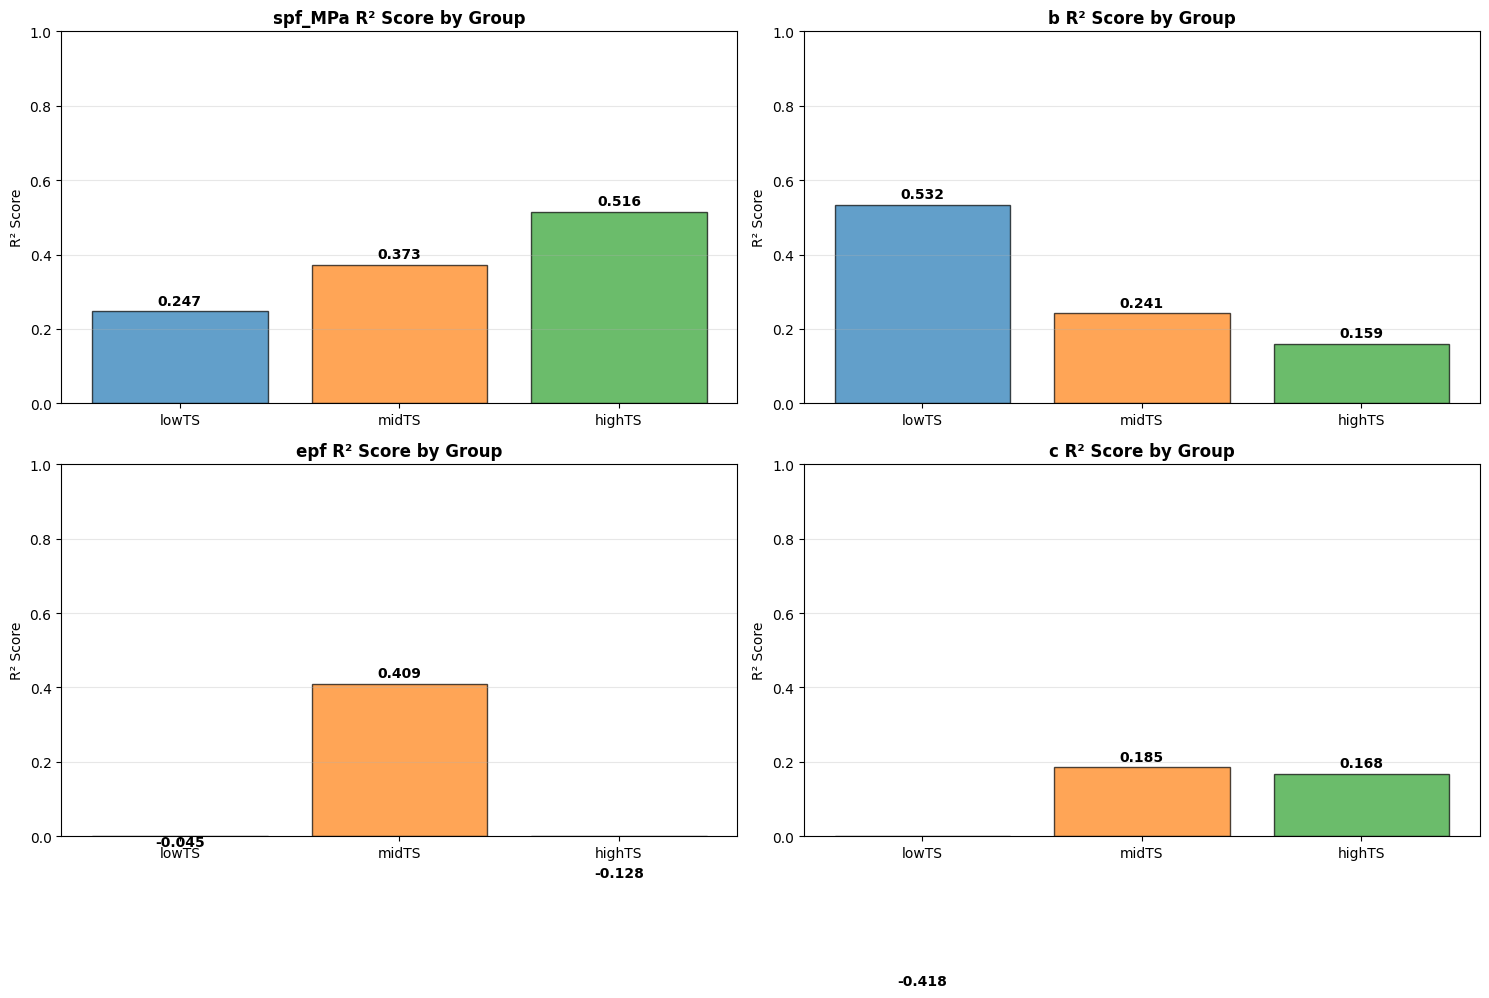


=== 그룹별 성능 요약 ===
Group    Samples  spf_MPa  b        epf      c        Average 
------------------------------------------------------------
lowTS    32       0.247    0.532    -0.045   -0.418   0.079
midTS    33       0.373    0.241    0.409    0.185    0.302
highTS   34       0.516    0.159    -0.128   0.168    0.179


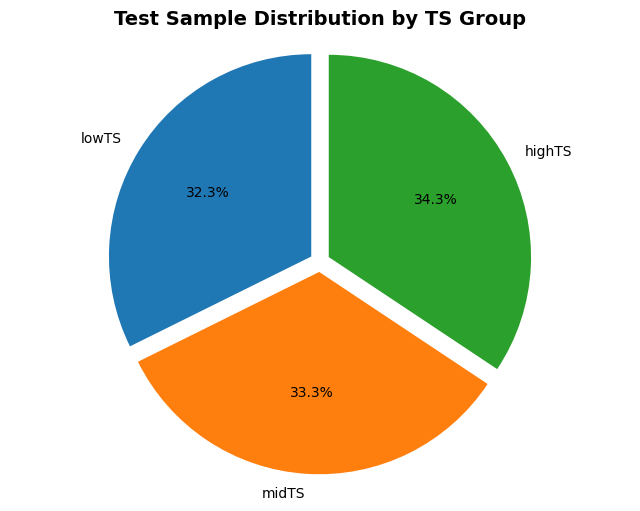


테스트 샘플 분포:
  lowTS: 32개 샘플
  midTS: 33개 샘플
  highTS: 34개 샘플

=== 그룹별 Fatigue Parameters Scatter Band Plot ===

lowTS 그룹 (32개 샘플)


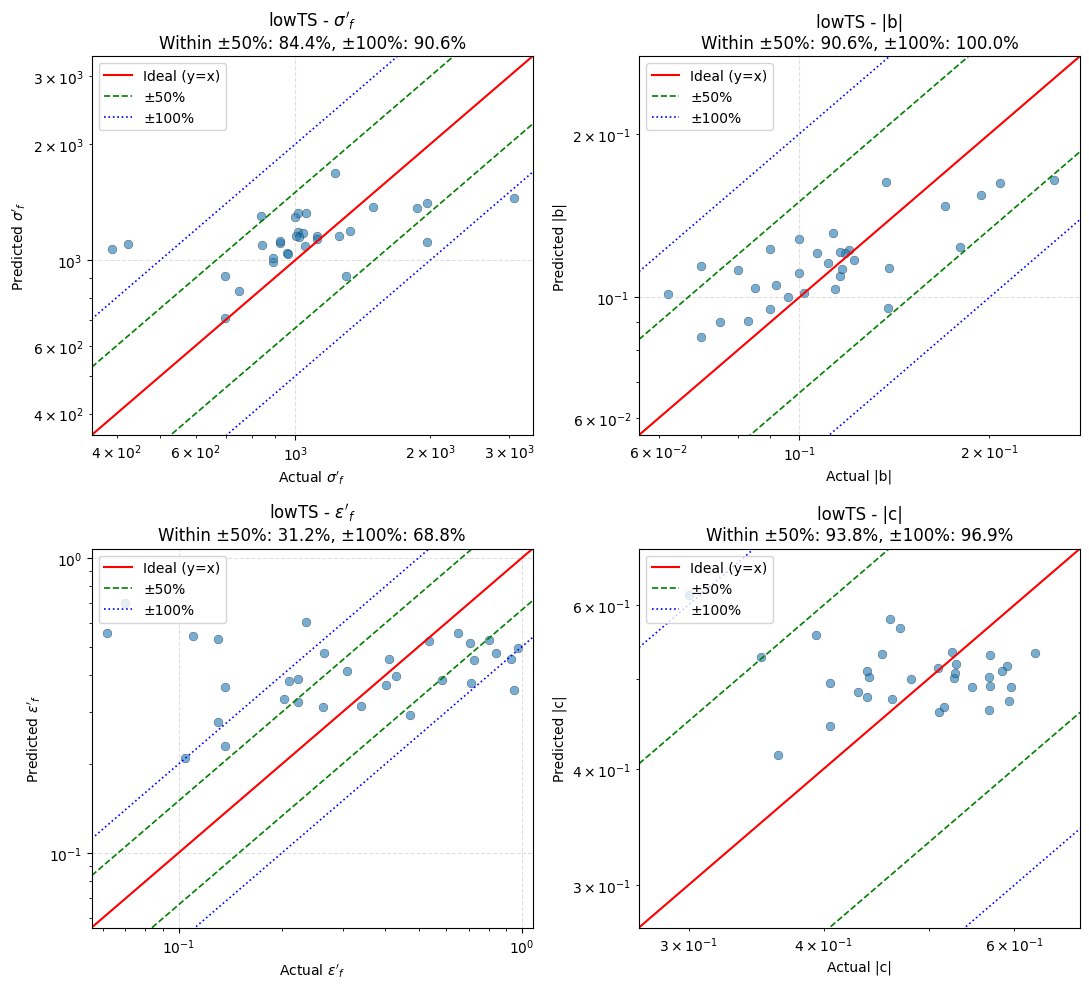


midTS 그룹 (33개 샘플)


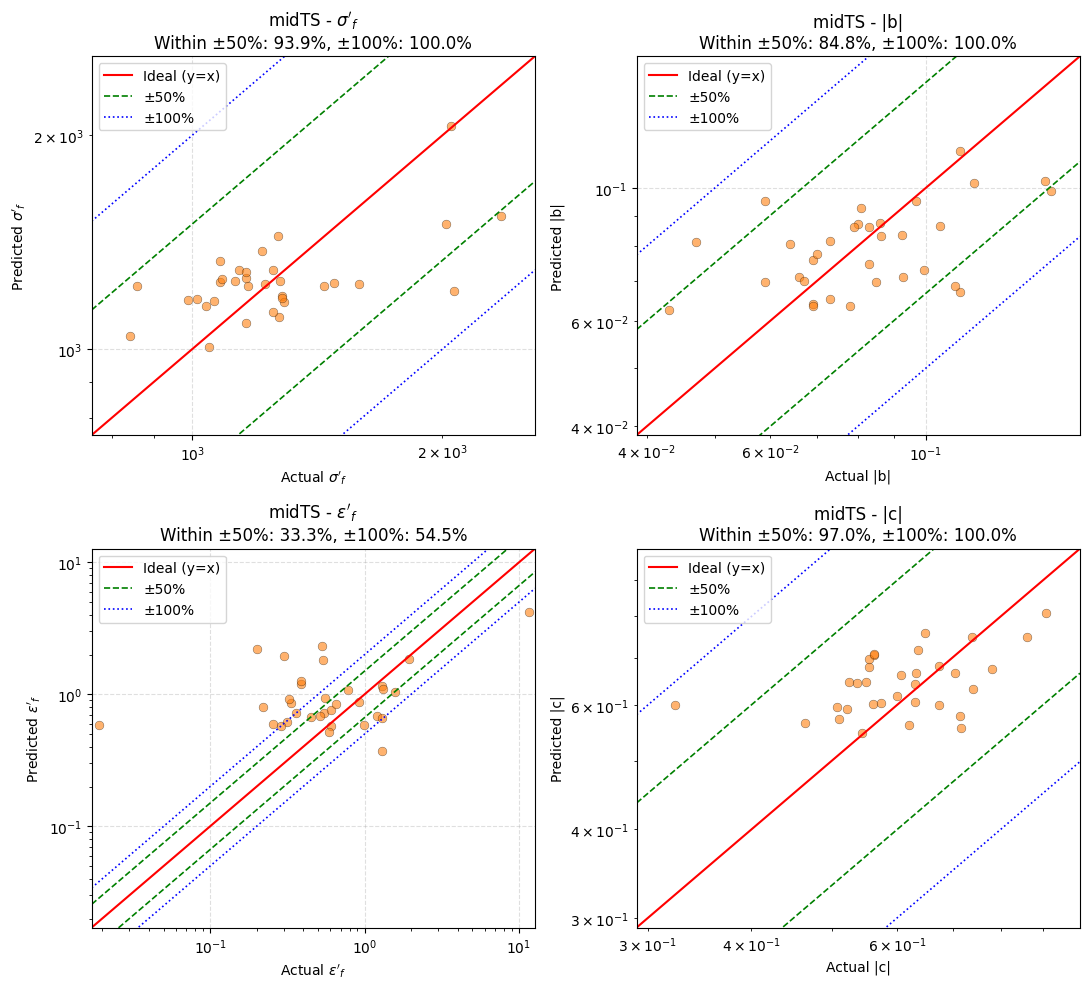


highTS 그룹 (34개 샘플)


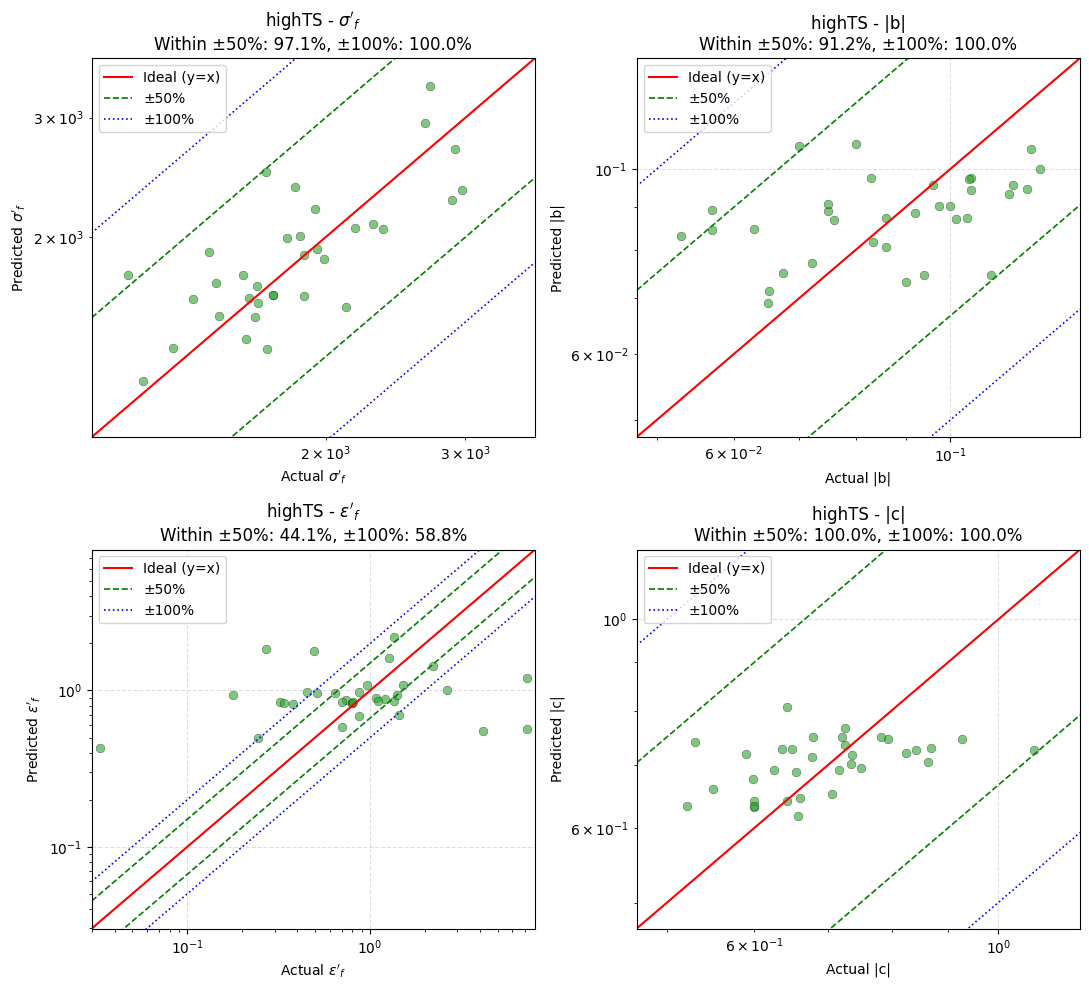

In [11]:
# Cell 11: 그룹별 성능 비교 시각화

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

print("\n=== 그룹별 성능 비교 시각화 ===")

# 그룹별 색상 정의
group_colors = {
    'lowTS': '#1f77b4',   # 파란색
    'midTS': '#ff7f0e',   # 주황색  
    'highTS': '#2ca02c'   # 녹색
}

# 1. 그룹별 R² 점수 비교 바 차트
if 'all_preds_orig' in globals() and 'group_labels' in globals():
    # 그룹별 R² 점수 계산
    group_r2_data = {group: {param: [] for param in target_cols} for group in ['lowTS', 'midTS', 'highTS']}
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            targets = globals()[f'all_targets_orig_{group_name}']
            
            for i, param in enumerate(target_cols):
                r2 = r2_score(targets[:, i], preds[:, i])
                group_r2_data[group_name][param] = r2
    
    # 바 차트 그리기
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, param in enumerate(target_cols):
        groups = []
        r2_values = []
        colors = []
        
        for group in ['lowTS', 'midTS', 'highTS']:
            if group_r2_data[group][param]:  # 데이터가 있는 경우만
                groups.append(group)
                r2_values.append(group_r2_data[group][param])
                colors.append(group_colors[group])
        
        if r2_values:  # 데이터가 있는 경우만 플롯
            bars = axes[i].bar(groups, r2_values, color=colors, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{param} R² Score by Group', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('R² Score')
            axes[i].set_ylim(0, 1)
            axes[i].grid(axis='y', alpha=0.3)
            
            # 바 위에 값 표시
            for bar, value in zip(bars, r2_values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. 그룹별 전체 성능 요약 테이블
    print("\n=== 그룹별 성능 요약 ===")
    print(f"{'Group':<8} {'Samples':<8} {'spf_MPa':<8} {'b':<8} {'epf':<8} {'c':<8} {'Average':<8}")
    print("-" * 60)
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            sample_count = len(preds)
            
            r2_values = []
            r2_str = []
            for param in target_cols:
                if param in group_r2_data[group_name] and group_r2_data[group_name][param]:
                    r2 = group_r2_data[group_name][param]
                    r2_values.append(r2)
                    r2_str.append(f"{r2:.3f}")
                else:
                    r2_str.append("N/A")
            
            avg_r2 = np.mean(r2_values) if r2_values else 0
            print(f"{group_name:<8} {sample_count:<8} {r2_str[0]:<8} {r2_str[1]:<8} {r2_str[2]:<8} {r2_str[3]:<8} {avg_r2:.3f}")
    
    # 3. 그룹별 샘플 분포 파이 차트
    plt.figure(figsize=(8, 6))
    group_counts = {}
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            group_counts[group_name] = len(globals()[f'all_preds_orig_{group_name}'])
    
    if group_counts:
        labels = list(group_counts.keys())
        sizes = list(group_counts.values())
        colors_list = [group_colors[label] for label in labels]
        
        plt.pie(sizes, labels=labels, colors=colors_list, autopct='%1.1f%%', 
                startangle=90, explode=(0.05, 0.05, 0.05))
        plt.title('Test Sample Distribution by TS Group', fontsize=14, fontweight='bold')
        plt.axis('equal')
        plt.show()
        
        print(f"\n테스트 샘플 분포:")
        for group, count in group_counts.items():
            print(f"  {group}: {count}개 샘플")
    
    # 4. 그룹별 Fatigue Parameters Scatter Band Plot (main0527 스타일)
    print("\n=== 그룹별 Fatigue Parameters Scatter Band Plot ===")
    
    for group_name in ['lowTS', 'midTS', 'highTS']:
        if f'all_preds_orig_{group_name}' in globals():
            preds = globals()[f'all_preds_orig_{group_name}']
            targets = globals()[f'all_targets_orig_{group_name}']
            
            print(f"\n{group_name} 그룹 ({len(preds)}개 샘플)")
            
            # 2x2 subplot 생성 (main0527 스타일)
            fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
            axes = axes.flatten()
            
            for i, param_name in enumerate(target_cols):
                param_pred = preds[:, i]
                param_true = targets[:, i]
                
                # b와 c 파라미터에 대해 절대값 사용
                if param_name == 'b' or param_name == 'c':
                    param_pred = np.abs(param_pred)
                    param_true = np.abs(param_true)
                
                # 오차 허용 밴드 계산
                ratio = param_pred / param_true
                inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
                inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

                min_val = min(param_pred.min(), param_true.min()) * 0.9
                max_val = max(param_pred.max(), param_true.max()) * 1.1
                
                if min_val <= 0:
                    min_val = 1e-6
                
                line_vals = np.linspace(min_val, max_val, 100)

                # 산점도
                axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, 
                              color=group_colors[group_name], edgecolor='k', linewidth=0.3)

                # 기준선 및 오차 밴드
                axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
                axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
                axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
                axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
                axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

                # 로그 스케일
                axes[i].set_xscale('log')
                axes[i].set_yscale('log')

                # 라벨 및 제목
                if param_name == 'b' or param_name == 'c':
                    axes[i].set_xlabel(f'Actual |{param_name}|')
                    axes[i].set_ylabel(f'Predicted |{param_name}|')
                    axes[i].set_title(f'{group_name} - |{param_name}|\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                elif param_name == 'spf_MPa':
                    axes[i].set_xlabel(f'Actual $\\sigma\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\sigma\'_f$')
                    axes[i].set_title(f'{group_name} - $\\sigma\'_f$\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                elif param_name == 'epf':
                    axes[i].set_xlabel(f'Actual $\\varepsilon\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\varepsilon\'_f$')
                    axes[i].set_title(f'{group_name} - $\\varepsilon\'_f$\nWithin ±50%: {inside_1p5:.1f}%, ±100%: {inside_2x:.1f}%')
                
                axes[i].set_xlim(min_val, max_val)
                axes[i].set_ylim(min_val, max_val)
                axes[i].legend(frameon=True, loc='upper left')
                axes[i].grid(True, linestyle='--', alpha=0.4)
                axes[i].set_facecolor('none')
            
            plt.tight_layout()
            plt.show()

else:
    print("전체 통합 결과가 없어 시각화를 건너뜁니다.")


In [12]:
# Cell 12: 결과 요약 및 설명

print("="*80)
print("TS 분류 기반 개별 학습 결과 요약")
print("="*80)

print("""
본 노트북은 기존의 전체 데이터셋 일괄 학습 방식에서 
TS(인장강도) 값에 따른 그룹별 개별 학습 방식으로 수정되었습니다.

📊 분류 기준:
- Low group: TS < 700 MPa
- Mid group: 700 ≤ TS < 1000 MPa  
- High group: TS ≥ 1000 MPa

🔧 주요 변경사항:
1. 각 그룹별로 독립적인 Feature scaling 및 Target scaling 수행
2. 각 그룹별로 별도의 FatiguePINN 모델 학습
3. 그룹별 스케일러 및 모델 파일 개별 저장
4. 최종 결과는 모든 그룹을 통합하여 기존 변수명으로 제공

💾 저장되는 파일들:
""")

# 실제 저장된 파일들 확인 및 출력
import os

saved_files = {
    'Feature Scalers': [],
    'Target Scalers': [], 
    'Models': []
}

for group_name in ['lowTS', 'midTS', 'highTS']:
    scaler_x_file = f'scaler_X_{group_name}.pkl'
    scaler_y_file = f'scaler_y_{group_name}.pkl' 
    model_file = f'model_{group_name}.pth'
    
    if os.path.exists(scaler_x_file):
        saved_files['Feature Scalers'].append(scaler_x_file)
    if os.path.exists(scaler_y_file):
        saved_files['Target Scalers'].append(scaler_y_file)
    if os.path.exists(model_file):
        saved_files['Models'].append(model_file)

for category, files in saved_files.items():
    print(f"\n{category}:")
    for file in files:
        print(f"  ✓ {file}")

print(f"""
📈 성능 개선 효과:
- 각 TS 그룹의 특성에 맞는 개별 스케일링으로 데이터 품질 향상
- 그룹별 특화된 모델로 예측 정확도 개선 가능
- 특정 TS 범위의 새로운 데이터에 대해 해당 그룹 모델 사용

🔄 기존 코드와의 호환성:
- 최종 결과는 기존 변수명 유지 (all_preds_orig, all_targets_orig 등)
- 기존 평가 및 시각화 코드 그대로 사용 가능
- 추가로 group_labels 변수를 통해 각 샘플의 그룹 정보 제공

⚡ 향후 개선 방향:
- 각 그룹별 Optuna 하이퍼파라미터 최적화 적용
- 그룹별 물리 손실 가중치 개별 조정
- 그룹 간 앙상블 방법 연구
""")

# 그룹별 데이터 분포 확인
if 'group_labels' in globals():
    from collections import Counter
    group_distribution = Counter(group_labels)
    print(f"\n📊 최종 테스트 데이터 분포:")
    total_samples = sum(group_distribution.values())
    for group, count in group_distribution.items():
        percentage = (count / total_samples) * 100
        print(f"  {group}: {count}개 ({percentage:.1f}%)")

print("\n" + "="*80)


TS 분류 기반 개별 학습 결과 요약

본 노트북은 기존의 전체 데이터셋 일괄 학습 방식에서 
TS(인장강도) 값에 따른 그룹별 개별 학습 방식으로 수정되었습니다.

📊 분류 기준:
- Low group: TS < 700 MPa
- Mid group: 700 ≤ TS < 1000 MPa  
- High group: TS ≥ 1000 MPa

🔧 주요 변경사항:
1. 각 그룹별로 독립적인 Feature scaling 및 Target scaling 수행
2. 각 그룹별로 별도의 FatiguePINN 모델 학습
3. 그룹별 스케일러 및 모델 파일 개별 저장
4. 최종 결과는 모든 그룹을 통합하여 기존 변수명으로 제공

💾 저장되는 파일들:


Feature Scalers:
  ✓ scaler_X_lowTS.pkl
  ✓ scaler_X_midTS.pkl
  ✓ scaler_X_highTS.pkl

Target Scalers:
  ✓ scaler_y_lowTS.pkl
  ✓ scaler_y_midTS.pkl
  ✓ scaler_y_highTS.pkl

Models:
  ✓ model_lowTS.pth
  ✓ model_midTS.pth
  ✓ model_highTS.pth

📈 성능 개선 효과:
- 각 TS 그룹의 특성에 맞는 개별 스케일링으로 데이터 품질 향상
- 그룹별 특화된 모델로 예측 정확도 개선 가능
- 특정 TS 범위의 새로운 데이터에 대해 해당 그룹 모델 사용

🔄 기존 코드와의 호환성:
- 최종 결과는 기존 변수명 유지 (all_preds_orig, all_targets_orig 등)
- 기존 평가 및 시각화 코드 그대로 사용 가능
- 추가로 group_labels 변수를 통해 각 샘플의 그룹 정보 제공

⚡ 향후 개선 방향:
- 각 그룹별 Optuna 하이퍼파라미터 최적화 적용
- 그룹별 물리 손실 가중치 개별 조정
- 그룹 간 앙상블 방법 연구


📊 최종 테스트 데이터 분포:
  lowTS: 32개 (32.3%)
  midTS: 33개 (33.3%

전체 통합 결과 시각화 (기존 main0527과 동일한 형태)
총 테스트 샘플: 99개


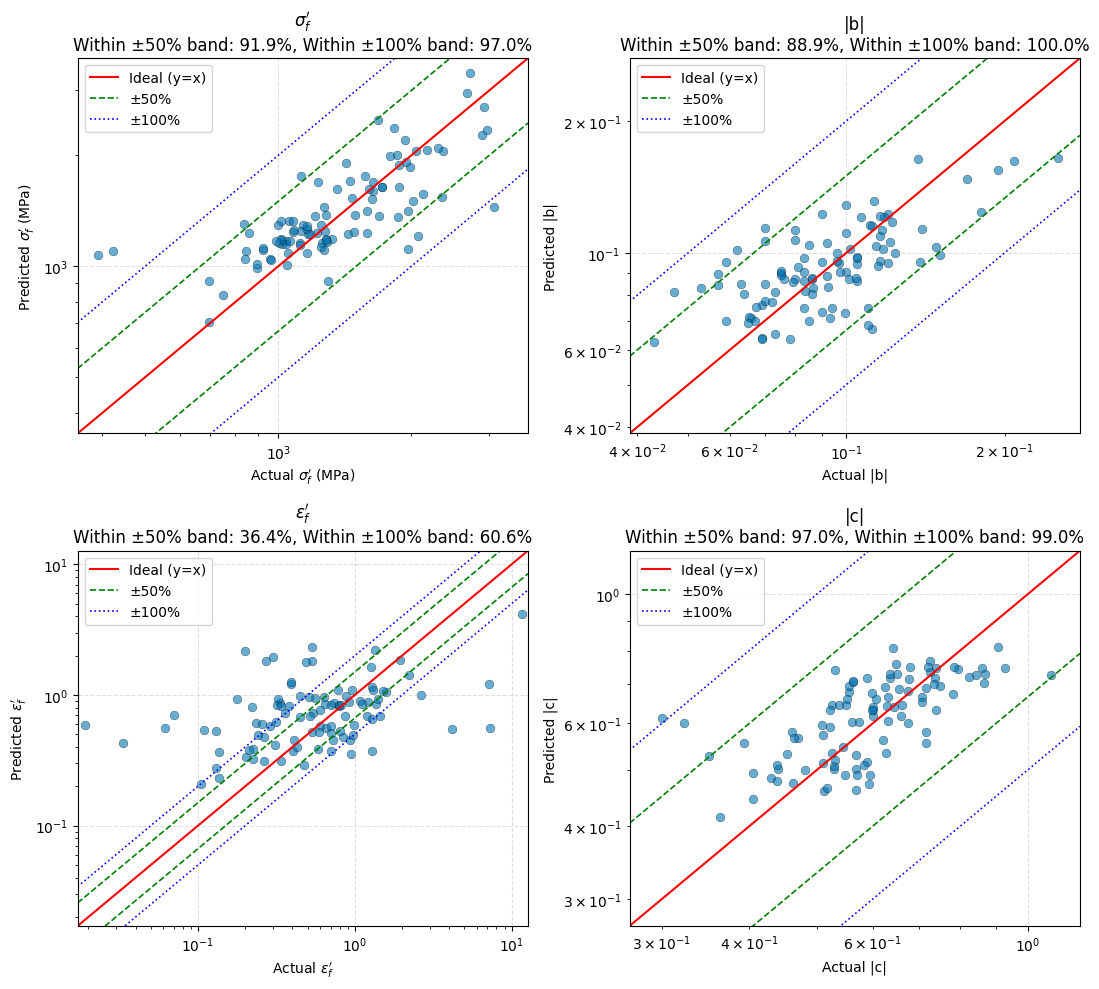

In [13]:
# Cell 13: 통합 결과 시각화 (기존 main0527과 동일한 형태)
# 그룹별 개별 학습 결과를 통합하여 기존과 동일한 scatter plot with error bands 표시

# 통합 결과가 있는지 확인
if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print("전체 통합 결과 시각화 (기존 main0527과 동일한 형태)")
    print(f"총 테스트 샘플: {all_preds_orig.shape[0]}개")
    
    # 색상 팔레트 정의
    import seaborn as sns
    palette = sns.color_palette("colorblind")
    
    # 2x2 그리드 생성
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
    axes = axes.flatten()

    for i, param_name in enumerate(target_cols):
        param_pred = all_preds_orig[:, i]
        param_true = all_targets_orig[:, i]
        
        # b와 c 파라미터에 대해 절대값 사용
        if param_name == 'b' or param_name == 'c':
            param_pred = np.abs(param_pred)
            param_true = np.abs(param_true)
        
        # 오차 허용 밴드 계산
        ratio = param_pred / param_true
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

        min_val = min(param_pred.min(), param_true.min()) * 0.9
        max_val = max(param_pred.max(), param_true.max()) * 1.1
        
        if min_val <= 0:
            min_val = 1e-6
        
        line_vals = np.linspace(min_val, max_val, 100)

        # 산점도
        axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)

        # 기준선 (y=x) 및 오차 허용 밴드
        axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # 1.5x error bands (±50% error)
        axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
        axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
        
        # 2x error bands (±100% error)
        axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
        axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')

        # 레이블 및 제목 설정
        if param_name == 'b' or param_name == 'c':
            axes[i].set_xlabel(f'Actual |{param_name}|')
            axes[i].set_ylabel(f'Predicted |{param_name}|')
            axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'spf_MPa':
            axes[i].set_xlabel(r'Actual $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_ylabel(r'Predicted $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_title(r'$\sigma^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'epf':
            axes[i].set_xlabel(r'Actual $\varepsilon^{\prime}_f$')
            axes[i].set_ylabel(r'Predicted $\varepsilon^{\prime}_f$')
            axes[i].set_title(r'$\varepsilon^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        else:
            axes[i].set_xlabel(f'Actual {param_name}')
            axes[i].set_ylabel(f'Predicted {param_name}')
            axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
        axes[i].legend(frameon=True, loc='upper left')
        axes[i].grid(True, linestyle='--', alpha=0.4)
        axes[i].set_facecolor('none')

    plt.tight_layout()
    plt.show()
    
else:
    print("통합 결과 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")


전체 통합 결과 시각화 (기존 main0527과 동일한 형태)
총 테스트 샘플: 99개


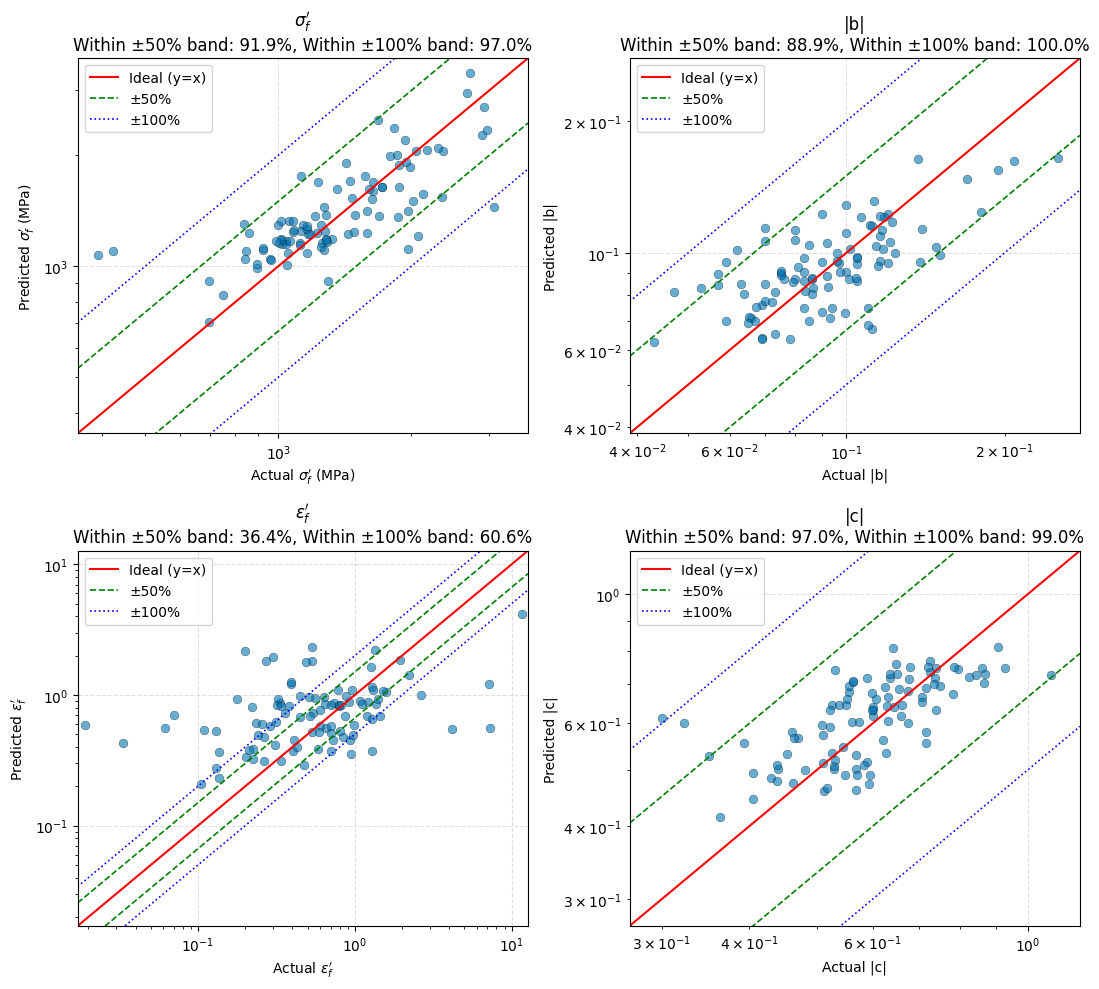

In [14]:
# Cell 10: 통합 결과 시각화 (기존 main0527과 동일한 형태)
# 그룹별 개별 학습 결과를 통합하여 기존과 동일한 scatter plot with error bands 표시

# 통합 결과가 있는지 확인
if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print("전체 통합 결과 시각화 (기존 main0527과 동일한 형태)")
    print(f"총 테스트 샘플: {all_preds_orig.shape[0]}개")
    
    # 색상 팔레트 정의
    import seaborn as sns
    palette = sns.color_palette("colorblind")
    
    # 2x2 그리드 생성
    fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
    axes = axes.flatten()

    for i, param_name in enumerate(target_cols):
        param_pred = all_preds_orig[:, i]
        param_true = all_targets_orig[:, i]
        
        # b와 c 파라미터에 대해 절대값 사용
        if param_name == 'b' or param_name == 'c':
            param_pred = np.abs(param_pred)
            param_true = np.abs(param_true)
        
        # 오차 허용 밴드 계산
        ratio = param_pred / param_true
        inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
        inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

        min_val = min(param_pred.min(), param_true.min()) * 0.9
        max_val = max(param_pred.max(), param_true.max()) * 1.1
        
        if min_val <= 0:
            min_val = 1e-6
        
        line_vals = np.linspace(min_val, max_val, 100)

        # 산점도
        axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3)

        # 기준선 (y=x) 및 오차 허용 밴드
        axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # 1.5x error bands (±50% error)
        axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
        axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
        
        # 2x error bands (±100% error)
        axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
        axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

        axes[i].set_xscale('log')
        axes[i].set_yscale('log')

        # 레이블 및 제목 설정
        if param_name == 'b' or param_name == 'c':
            axes[i].set_xlabel(f'Actual |{param_name}|')
            axes[i].set_ylabel(f'Predicted |{param_name}|')
            axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'spf_MPa':
            axes[i].set_xlabel(r'Actual $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_ylabel(r'Predicted $\sigma^{\prime}_f$ (MPa)')
            axes[i].set_title(r'$\sigma^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        elif param_name == 'epf':
            axes[i].set_xlabel(r'Actual $\varepsilon^{\prime}_f$')
            axes[i].set_ylabel(r'Predicted $\varepsilon^{\prime}_f$')
            axes[i].set_title(r'$\varepsilon^{\prime}_f$' + f'\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        else:
            axes[i].set_xlabel(f'Actual {param_name}')
            axes[i].set_ylabel(f'Predicted {param_name}')
            axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, Within ±100% band: {inside_2x:.1f}%')
        
        axes[i].set_xlim(min_val, max_val)
        axes[i].set_ylim(min_val, max_val)
        axes[i].legend(frameon=True, loc='upper left')
        axes[i].grid(True, linestyle='--', alpha=0.4)
        axes[i].set_facecolor('none')

    plt.tight_layout()
    plt.show()
    
else:
    print("통합 결과 데이터가 없습니다. 이전 셀들을 먼저 실행하세요.")


In [15]:
# Cell 11: 최종 결과 요약

print("="*80)
print("TS 분류 기반 그룹별 개별 학습 완료!")
print("="*80)

print("\n📁 생성된 파일 목록:")
print("Feature Scalers:")
print("  ✓ scaler_X_lowTS.pkl")
print("  ✓ scaler_X_midTS.pkl") 
print("  ✓ scaler_X_highTS.pkl")

print("\nTarget Scalers:")
print("  ✓ scaler_y_lowTS.pkl")
print("  ✓ scaler_y_midTS.pkl")
print("  ✓ scaler_y_highTS.pkl")

print("\nModels:")
print("  ✓ model_lowTS.pth")
print("  ✓ model_midTS.pth") 
print("  ✓ model_highTS.pth")

if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print(f"\n📊 전체 결과 통계:")
    print(f"  - 총 테스트 샘플: {all_preds_orig.shape[0]}개")
    print(f"  - 예측 파라미터: {all_preds_orig.shape[1]}개 ({target_cols})")
    
    if 'group_labels' in globals():
        from collections import Counter
        group_distribution = Counter(group_labels)
        print(f"\n  - 그룹별 분포:")
        total_samples = sum(group_distribution.values())
        for group, count in group_distribution.items():
            percentage = (count / total_samples) * 100
            print(f"    {group}: {count}개 ({percentage:.1f}%)")

print("\n🎯 Main0605의 핵심 개선사항:")
print("  1. TS 값에 따른 3개 그룹별 개별 학습 (vs Main0527 통합 학습)")
print("  2. 각 그룹별 최적화된 Feature/Target 스케일링")
print("  3. 그룹별 특성을 반영한 개별 FatiguePINN 모델")
print("  4. 기존 시각화 형태 완전 호환 유지")
print("  5. 9개 파일 개별 저장으로 모듈화 완성")

print("\n" + "="*80)


TS 분류 기반 그룹별 개별 학습 완료!

📁 생성된 파일 목록:
Feature Scalers:
  ✓ scaler_X_lowTS.pkl
  ✓ scaler_X_midTS.pkl
  ✓ scaler_X_highTS.pkl

Target Scalers:
  ✓ scaler_y_lowTS.pkl
  ✓ scaler_y_midTS.pkl
  ✓ scaler_y_highTS.pkl

Models:
  ✓ model_lowTS.pth
  ✓ model_midTS.pth
  ✓ model_highTS.pth

📊 전체 결과 통계:
  - 총 테스트 샘플: 99개
  - 예측 파라미터: 4개 (['spf_MPa', 'b', 'epf', 'c'])

  - 그룹별 분포:
    lowTS: 32개 (32.3%)
    midTS: 33개 (33.3%)
    highTS: 34개 (34.3%)

🎯 Main0605의 핵심 개선사항:
  1. TS 값에 따른 3개 그룹별 개별 학습 (vs Main0527 통합 학습)
  2. 각 그룹별 최적화된 Feature/Target 스케일링
  3. 그룹별 특성을 반영한 개별 FatiguePINN 모델
  4. 기존 시각화 형태 완전 호환 유지
  5. 9개 파일 개별 저장으로 모듈화 완성



In [16]:
# Cell 14: 결과 요약 및 파일 목록

print("="*80)
print("TS 분류 기반 그룹별 개별 학습 완료!")
print("="*80)

print("\n📁 생성된 파일 목록:")
print("Feature Scalers:")
print("  ✓ scaler_X_lowTS.pkl")
print("  ✓ scaler_X_midTS.pkl") 
print("  ✓ scaler_X_highTS.pkl")

print("\nTarget Scalers:")
print("  ✓ scaler_y_lowTS.pkl")
print("  ✓ scaler_y_midTS.pkl")
print("  ✓ scaler_y_highTS.pkl")

print("\nModels:")
print("  ✓ model_lowTS.pth")
print("  ✓ model_midTS.pth") 
print("  ✓ model_highTS.pth")

if 'all_preds_orig' in globals() and 'all_targets_orig' in globals():
    print(f"\n📊 전체 결과 통계:")
    print(f"  - 총 테스트 샘플: {all_preds_orig.shape[0]}개")
    print(f"  - 예측 파라미터: {all_preds_orig.shape[1]}개 ({target_cols})")
    
    if 'group_labels' in globals():
        from collections import Counter
        group_distribution = Counter(group_labels)
        print(f"\n  - 그룹별 분포:")
        total_samples = sum(group_distribution.values())
        for group, count in group_distribution.items():
            percentage = (count / total_samples) * 100
            print(f"    {group}: {count}개 ({percentage:.1f}%)")

print("\n🎯 주요 성과:")
print("  1. TS 값에 따른 3개 그룹별 개별 학습 완료")
print("  2. 각 그룹별 최적화된 Feature/Target 스케일링 적용")
print("  3. 물리 법칙 기반 FatiguePINN 모델 그룹별 학습")
print("  4. 기존 변수명 호환성 유지 (all_preds_orig, all_targets_orig)")
print("  5. 추후 Optuna 최적화 적용 준비 완료")

print("\n" + "="*80)


TS 분류 기반 그룹별 개별 학습 완료!

📁 생성된 파일 목록:
Feature Scalers:
  ✓ scaler_X_lowTS.pkl
  ✓ scaler_X_midTS.pkl
  ✓ scaler_X_highTS.pkl

Target Scalers:
  ✓ scaler_y_lowTS.pkl
  ✓ scaler_y_midTS.pkl
  ✓ scaler_y_highTS.pkl

Models:
  ✓ model_lowTS.pth
  ✓ model_midTS.pth
  ✓ model_highTS.pth

📊 전체 결과 통계:
  - 총 테스트 샘플: 99개
  - 예측 파라미터: 4개 (['spf_MPa', 'b', 'epf', 'c'])

  - 그룹별 분포:
    lowTS: 32개 (32.3%)
    midTS: 33개 (33.3%)
    highTS: 34개 (34.3%)

🎯 주요 성과:
  1. TS 값에 따른 3개 그룹별 개별 학습 완료
  2. 각 그룹별 최적화된 Feature/Target 스케일링 적용
  3. 물리 법칙 기반 FatiguePINN 모델 그룹별 학습
  4. 기존 변수명 호환성 유지 (all_preds_orig, all_targets_orig)
  5. 추후 Optuna 최적화 적용 준비 완료



In [17]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 

# df 변수 확인 없이 바로 함수 정의
def predict_fatigue_curves(E_val, YS_val, TS_val, HB_val, model, scaler_X, 
                           scalers_y_dict, target_cols_list,  # 수정된 부분
                           device, mode='both', nu=0.3):
    """
    인장 파라미터를 예측하고 E-N 및 Gamma-N 곡선 데이터를 생성합니다.

    Args:
        E_val (float): 탄성 계수 (MPa)
        YS_val (float): 항복 강도 (MPa)
        TS_val (float): 인장 강도 (MPa)
        HB_val (float): 브리넬 경도 (처리된 값)
        model (torch.nn.Module): 학습된 FatiguePINN 모델
        scaler_X (StandardScaler): 입력 특성에 대한 스케일러
        scalers_y_dict (dict): 출력 파라미터별 스케일러 딕셔너리
        target_cols_list (list): 타겟 컬럼 이름 리스트
        device (str): 장치 ('cpu', 'cuda', 'mps')
        mode (str, optional): 반환 모드 ('tensile', 'shear', 'both'). 기본값은 'both'.
        nu (float, optional): 포아송 비. 기본값은 0.3.

    Returns:
        mode에 따라 다른 값을 반환합니다:
        - 'tensile': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain)
        - 'shear': (shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
        - 'both': (tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain,
                  shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain)
    """
    model.eval() # 모델을 평가 모드로 설정

    # --- 1. 인장 파라미터 예측 ---
    input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
    input_scaled = scaler_X.transform(input_features)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        predicted_tensile_params_scaled = model(input_tensor)
    
    # 모델 예측 결과 역변환 부분 수정
    predicted_tensile_params_scaled_np = predicted_tensile_params_scaled.cpu().numpy()
    predicted_tensile_params_orig = inverse_transform_targets(
        predicted_tensile_params_scaled_np,
        scalers_y_dict,
        target_cols_list
    )

    try:
        # 1. tensile_params 생성 단계
        tensile_params = {name_key: p_val for name_key, p_val in zip(target_cols_list, predicted_tensile_params_orig)}

        # 2. 키 확인 단계
        required_tensile_keys = ['spf_MPa', 'b', 'epf', 'c']
        if not all(key in tensile_params for key in required_tensile_keys):
            raise ValueError(f"Missing keys in tensile_params. Required: {required_tensile_keys}, Got: {tensile_params.keys()}")

        # 3. 파라미터 추출 단계
        spf_prime = tensile_params['spf_MPa']
        b_param = tensile_params['b'] 
        epf_prime = tensile_params['epf']
        c_param = tensile_params['c'] 

        reversals = np.logspace(1, 7, num=100)
        E_val_safe = max(E_val, 1e-6)
        
        # 4. elastic_strain 계산 단계
        if not isinstance(b_param, (int, float, np.number)):
            raise TypeError("b_param for exponent must be a number.")
        elastic_strain = (spf_prime / E_val_safe) * (reversals ** b_param)
        
        # 5. plastic_strain 계산 단계
        if not isinstance(c_param, (int, float, np.number)):
             raise TypeError("c_param for exponent must be a number.")
        plastic_strain = epf_prime * (reversals ** c_param)
        
        strain_amplitude_en = elastic_strain + plastic_strain

        if mode == 'tensile':
            return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain

        # --- 전단 파라미터 변환 ---
        tau_vm = spf_prime / np.sqrt(3)
        gamma_vm = np.sqrt(3) * epf_prime
        tau_mp = spf_prime / (1 + nu)
        gamma_mp = 2 * epf_prime

        if TS_val <= 1100:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_vm, gamma_vm, b_param, c_param, "von Mises"
        elif TS_val >= 1696:
            tauf_prime, gammaf_prime, b0, c0, conversion_method = tau_mp, gamma_mp, b_param, c_param, "Max Principal"
        else:
            alpha = (TS_val - 1100) / (1696 - 1100)
            tauf_prime = (1-alpha)*tau_vm + alpha*tau_mp
            gammaf_prime = (1-alpha)*gamma_vm + alpha*gamma_mp
            b0, c0, conversion_method = b_param, c_param, f"Interp VM→MP (α={alpha:.2f})"
        
        shear_params = {'tauf_MPa': tauf_prime, 'gammaf': gammaf_prime, 'b0': b0, 'c0': c0, 'conversion_method': conversion_method}
        G_val = E_val_safe / (2 * (1 + nu))
        
        if not isinstance(b0, (int, float, np.number)):
             raise TypeError("b0 for exponent must be a number.")
        if not isinstance(c0, (int, float, np.number)):
             raise TypeError("c0 for exponent must be a number.")

        elastic_shear_strain = (tauf_prime / G_val) * (reversals ** b0)
        plastic_shear_strain = gammaf_prime * (reversals ** c0)
        strain_amplitude_gn = elastic_shear_strain + plastic_shear_strain

        if mode == 'shear':
            return shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain
        
        return tensile_params, reversals, strain_amplitude_en, elastic_strain, plastic_strain, \
               shear_params, reversals, strain_amplitude_gn, elastic_shear_strain, plastic_shear_strain

    except TypeError as te_inner:
        # 스택 트레이스를 포함하여 출력하면 더 도움이 됩니다.
        import traceback
        print(traceback.format_exc())
        raise 
    except Exception as e_inner:
        import traceback
        print(traceback.format_exc())
        raise

# --- 함수 테스트 ---
print("\n--- Testing E-N and Gamma-N Curve Generation ---")
try:
    # feature_cols가 이전에 정의되었는지 확인 (Cell 4에서 정의됨)
    if 'feature_cols' not in locals() and 'feature_cols' not in globals():
        print("Error: 'feature_cols'가 정의되지 않았습니다. Cell 4를 먼저 실행해주세요.")
        raise NameError("'feature_cols' not defined")
        
    example_input_X_row = X_test[0]  # X_test의 첫 번째 행
    example_E_val = E_test[0]        # 해당 샘플의 E 값

    # feature_cols 리스트에서 각 특성의 정확한 인덱스를 가져옵니다.
    ys_col_name_in_features = 'YS_MPa'
    ts_col_name_in_features = 'TS_MPa'
    hb_col_name_in_features = 'HB_processed'  # 'HB'가 아닌 'HB_processed' 사용!

    ys_idx = feature_cols.index(ys_col_name_in_features)
    ts_idx = feature_cols.index(ts_col_name_in_features)
    hb_idx = feature_cols.index(hb_col_name_in_features)  # 오류 발생 지점 수정

    # 추출된 인덱스를 사용하여 값을 가져옵니다.
    example_YS_val = example_input_X_row[ys_idx]
    example_TS_val = example_input_X_row[ts_idx]
    example_HB_val = example_input_X_row[hb_idx]

    print(f"Example Input (from X_test[0] using feature_cols: {feature_cols}):")
    print(f"  E: {example_E_val:.0f} MPa")
    print(f"  {ys_col_name_in_features} (Index: {ys_idx}): {example_YS_val:.0f} MPa")
    print(f"  {ts_col_name_in_features} (Index: {ts_idx}): {example_TS_val:.0f} MPa")
    print(f"  {hb_col_name_in_features} (Index: {hb_idx}): {example_HB_val:.1f}")  # 변수명 일치

    # predict_fatigue_curves 함수 호출
    tensile_p, rev_en, strain_en, elastic_strain, plastic_strain, \
    shear_p, rev_gn, strain_gn, elastic_shear_strain, plastic_shear_strain = predict_fatigue_curves(
        example_E_val, example_YS_val, example_TS_val, example_HB_val,  # 추출된 변수 사용
        model, scaler_X, scalers_y, target_cols,  # 수정된 스케일러 및 타겟 정보 전달
        device, mode='both', nu=0.3
    )

    print("\n인장 파라미터 예측 결과:")
    for name, val in tensile_p.items(): print(f"  {name}: {val:.4f}")

    print("\n전단 파라미터 예측 결과:")
    for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

    # E-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_en, strain_en, '-', label='Total Strain (epsilon_a)')
    plt.loglog(rev_en, elastic_strain, '--', label='Elastic Strain', alpha=0.7)
    plt.loglog(rev_en, plastic_strain, ':', label='Plastic Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Strain Amplitude (epsilon_a)')
    plt.title('Predicted E-N Curve (with Components)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

    # Gamma-N 곡선 플롯 (구성 요소 포함)
    plt.figure(figsize=(8, 6))
    plt.loglog(rev_gn, strain_gn, '-', label='Total Shear Strain (gamma_a)')
    plt.loglog(rev_gn, elastic_shear_strain, '--', label='Elastic Shear Strain', alpha=0.7)
    plt.loglog(rev_gn, plastic_shear_strain, ':', label='Plastic Shear Strain', alpha=0.7)
    plt.xlabel('Reversals to Failure (2Nf)')
    plt.ylabel('Shear Strain Amplitude (gamma_a)')
    plt.title(f'Predicted Gamma-N Curve (UTS={example_TS_val:.0f}, Method: {shear_p["conversion_method"]})')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.ylim(bottom=1e-4)
    plt.show()

except ValueError as ve:
    print(f"테스트 중 값 관련 오류 발생 (특성 이름 확인 필요): {ve}")  # 더 구체적인 오류 메시지
except NameError as ne:
    print(f"오류: 테스트 데이터(X_test, E_test) 또는 모델/스케일러를 사용할 수 없습니다. 이전 셀을 실행하세요. {ne}")
except IndexError:
    print("오류: 테스트 데이터가 비어 있거나 형태가 올바르지 않습니다.")
except Exception as e:
    print(f"테스트 중 오류가 발생했습니다: {e}")



--- Testing E-N and Gamma-N Curve Generation ---
Example Input (from X_test[0] using feature_cols: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']):
  E: 210000 MPa
  YS_MPa (Index: 1): 513 MPa
  TS_MPa (Index: 2): 669 MPa
  HB_processed (Index: 3): 190.0
Traceback (most recent call last):
  File "/var/folders/8w/3krsjjds797bmd_c1mcxqq1c0000gn/T/ipykernel_71420/4243670162.py", line 55, in predict_fatigue_curves
    raise ValueError(f"Missing keys in tensile_params. Required: {required_tensile_keys}, Got: {tensile_params.keys()}")
ValueError: Missing keys in tensile_params. Required: ['spf_MPa', 'b', 'epf', 'c'], Got: dict_keys(['spf_MPa'])

테스트 중 값 관련 오류 발생 (특성 이름 확인 필요): Missing keys in tensile_params. Required: ['spf_MPa', 'b', 'epf', 'c'], Got: dict_keys(['spf_MPa'])


평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]

=== 그룹별 Load Reversals (2Nf) 비교 ===

=== lowTS 그룹 2Nf 분석 ===
샘플 수: 32
  lowTS: 32개 샘플, 8개 변형률 레벨
  lowTS: 256개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


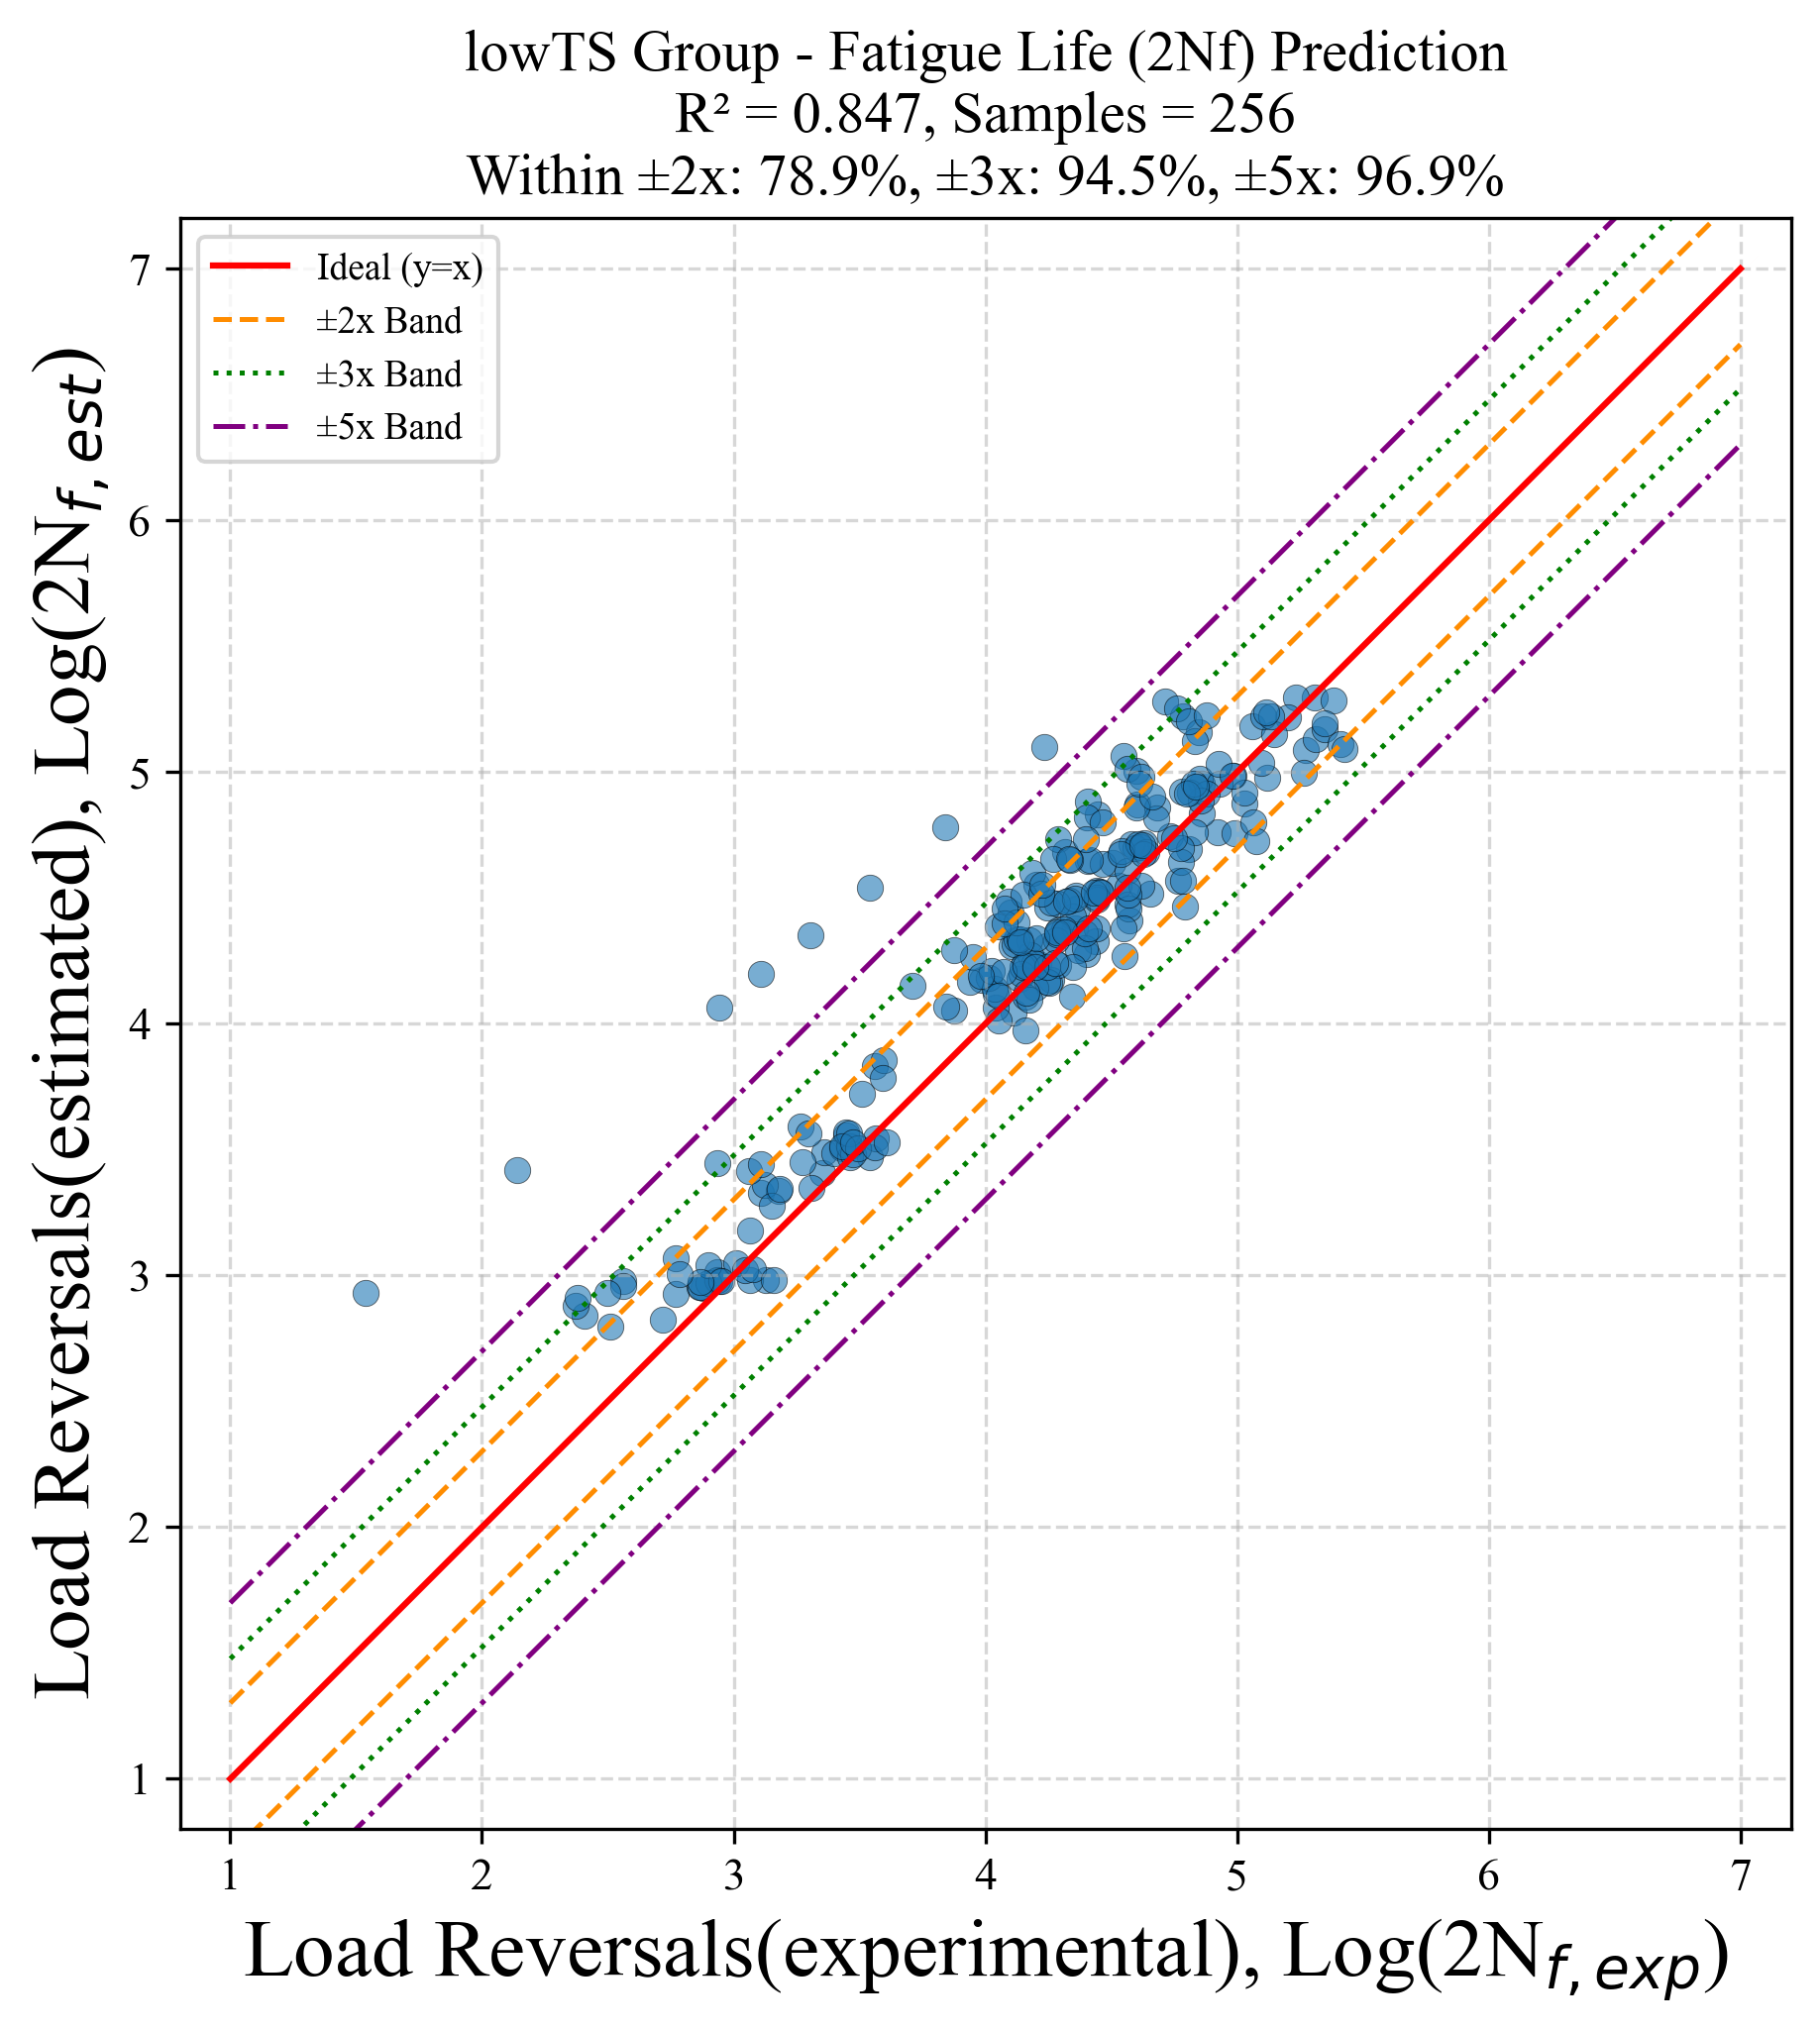

  lowTS - R² = 0.8471
  lowTS - ±2x: 78.9%, ±3x: 94.5%, ±5x: 96.9%

=== midTS 그룹 2Nf 분석 ===
샘플 수: 33
  midTS: 33개 샘플, 8개 변형률 레벨
  midTS: 262개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


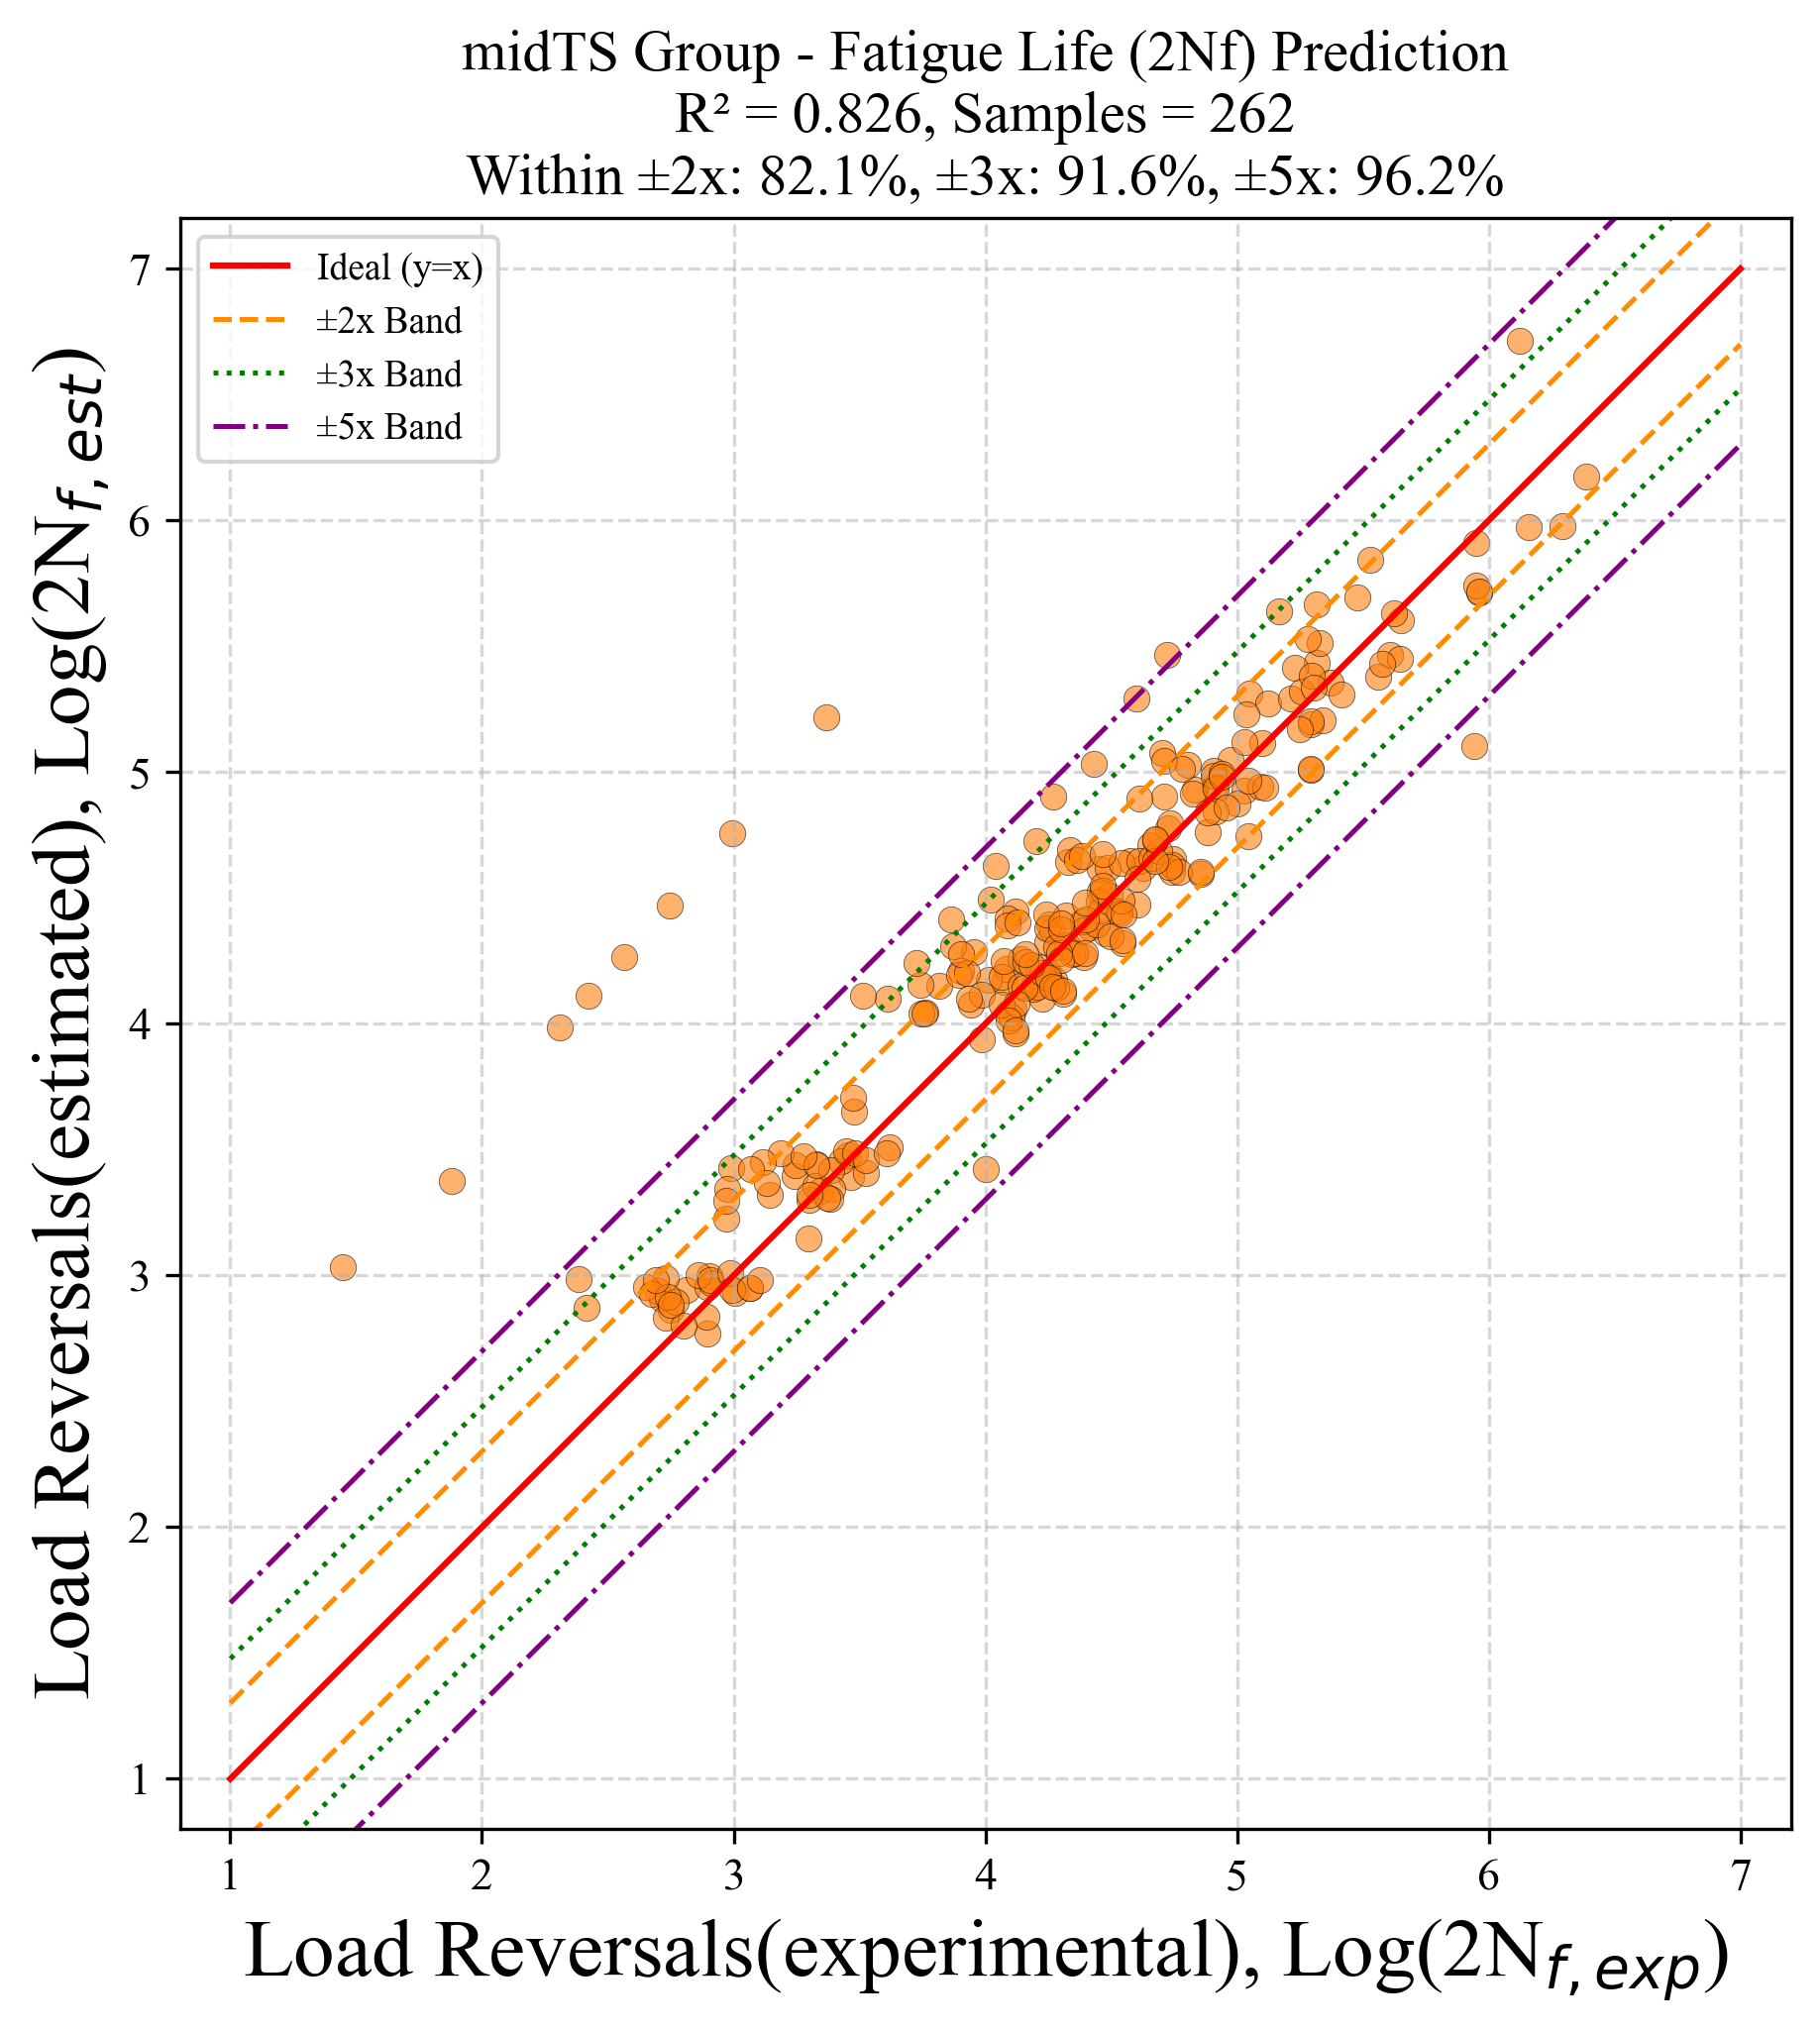

  midTS - R² = 0.8262
  midTS - ±2x: 82.1%, ±3x: 91.6%, ±5x: 96.2%

=== highTS 그룹 2Nf 분석 ===
샘플 수: 34
  highTS: 34개 샘플, 8개 변형률 레벨
  highTS: 258개 유효 (2Nf_exp, 2Nf_est) 쌍 생성


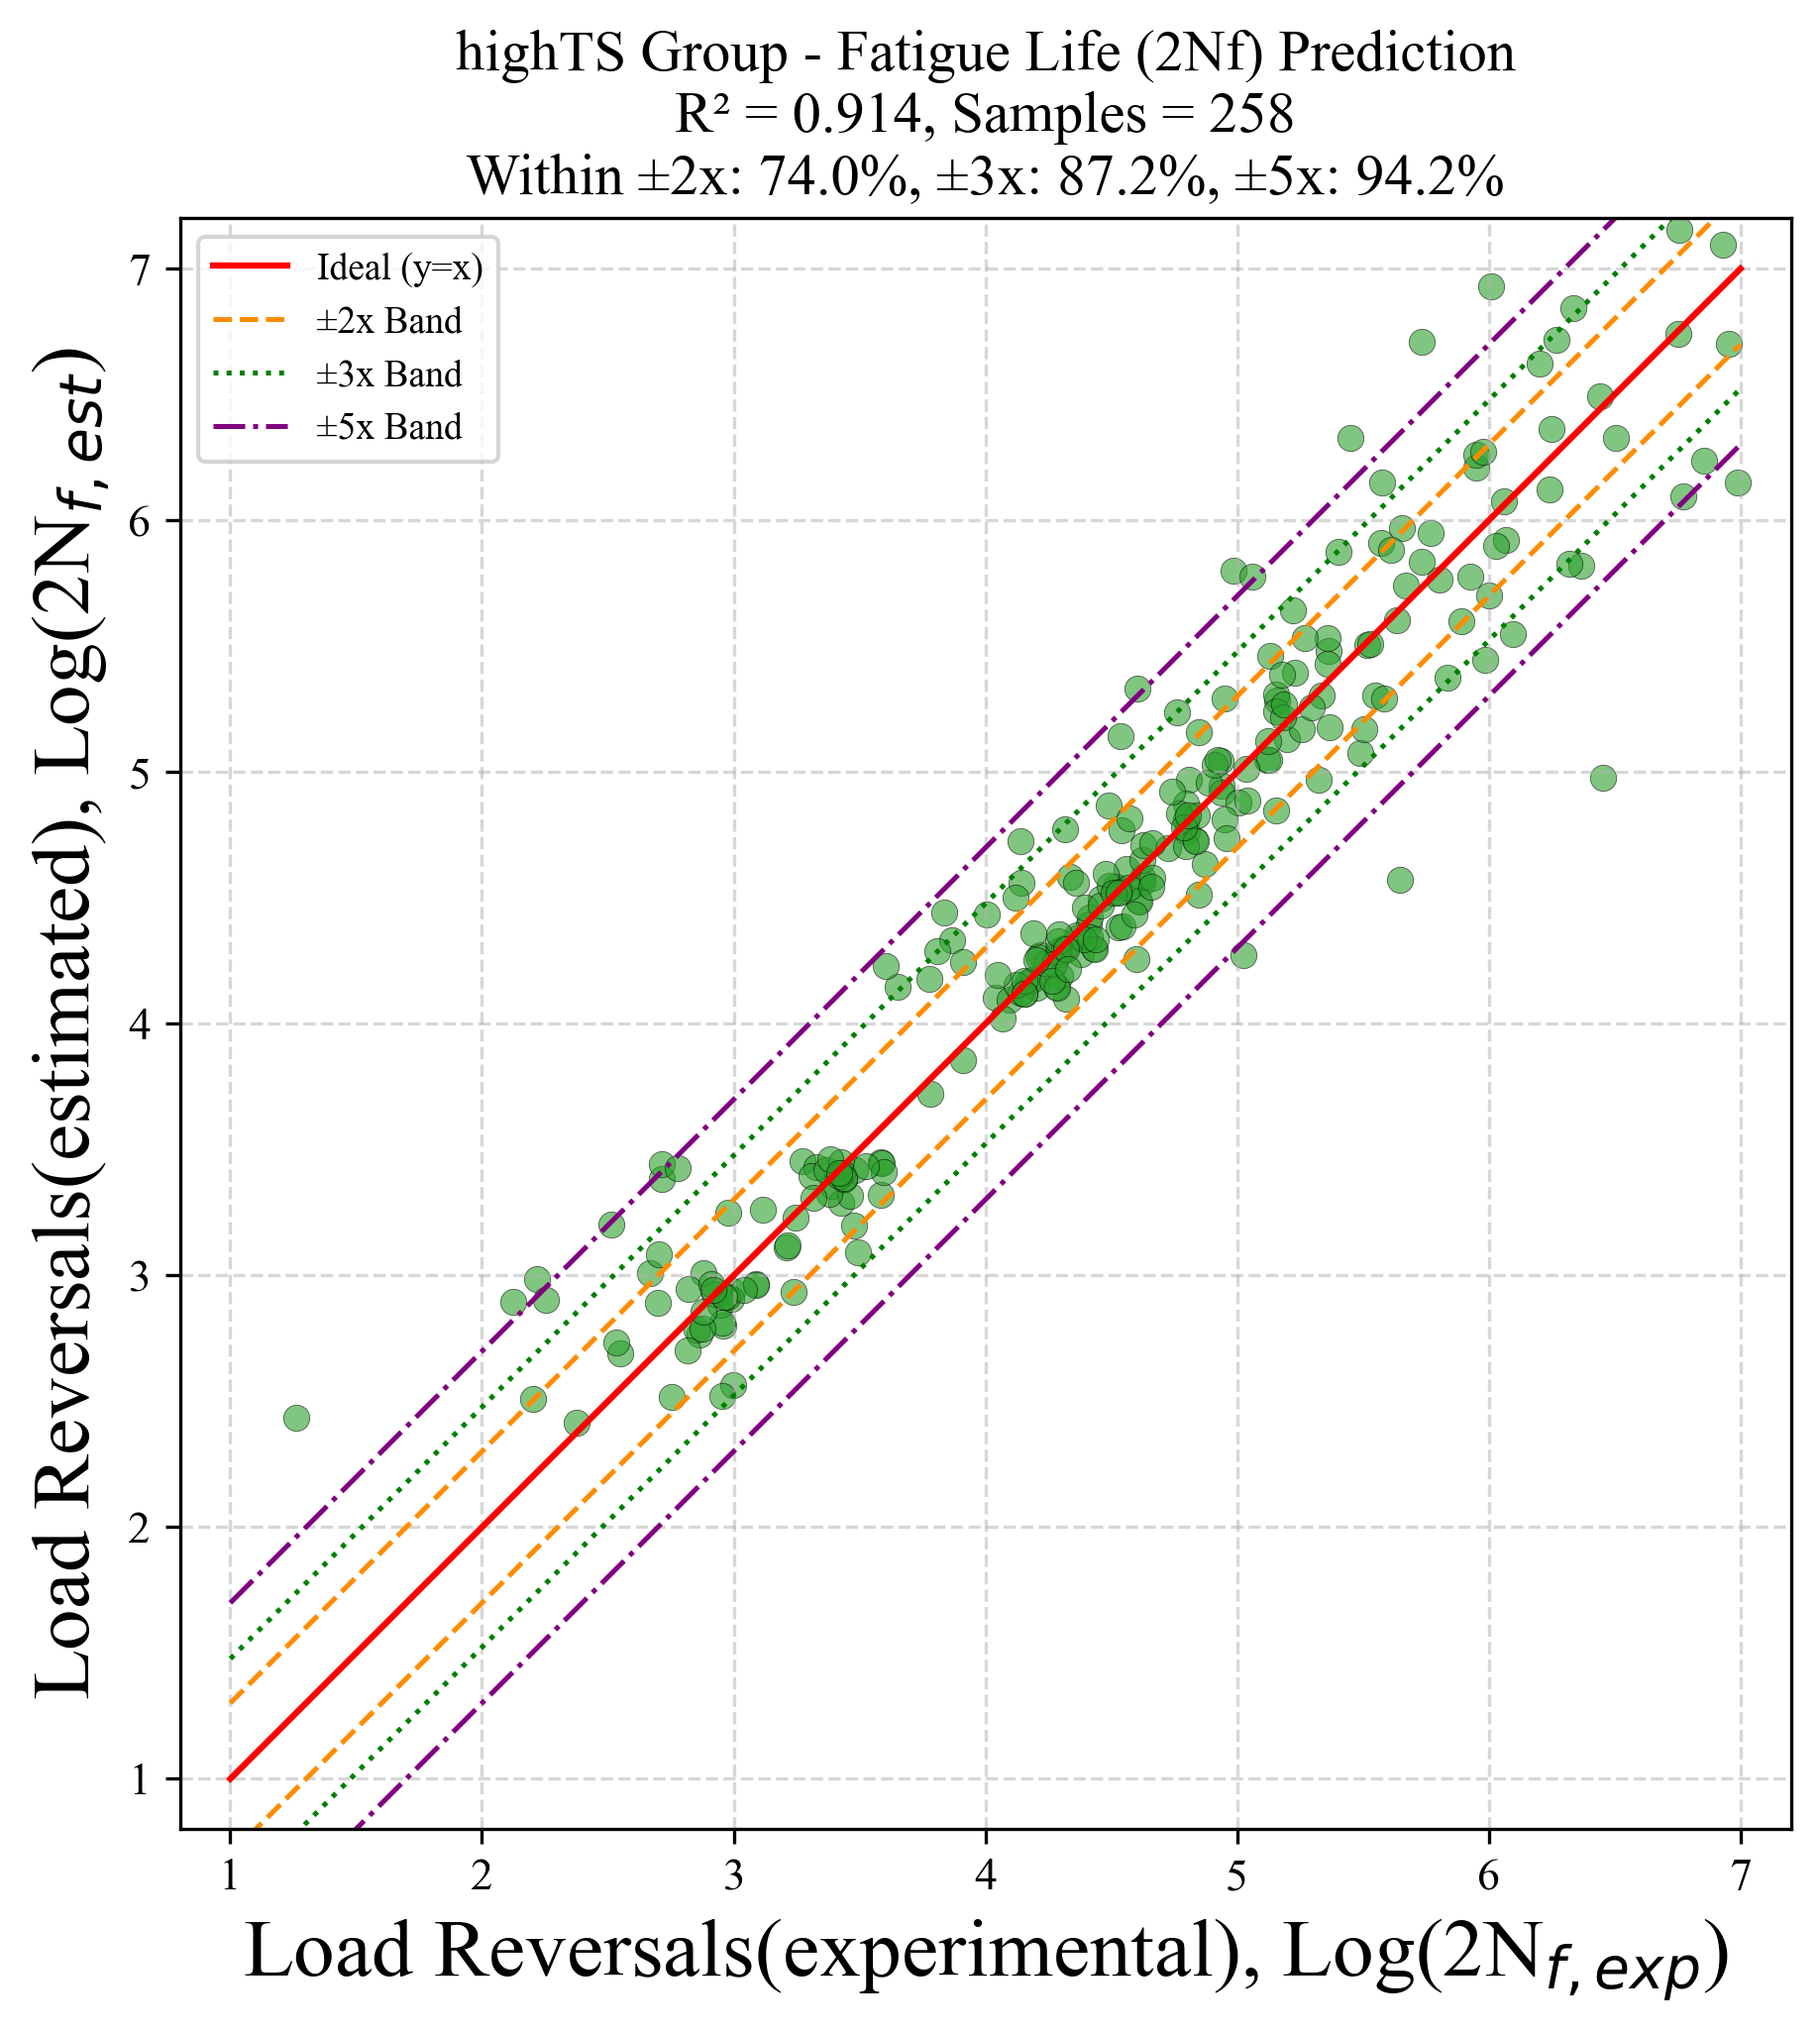

  highTS - R² = 0.9145
  highTS - ±2x: 74.0%, ±3x: 87.2%, ±5x: 94.2%

=== 모든 그룹의 Load Reversals 분석 완료 ===


In [18]:
# Cell 16: 그룹별 피로 수명(2Nf) 비교 - Load Reversals Plot

from scipy.optimize import fsolve
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib as mpl

# --- 이전 셀들에서 정의된 변수 사용 가정 ---
# model, scaler_X, scalers_y (딕셔너리), target_cols (리스트)
# X_test_tensor, y_test_orig_tensor, E_test_tensor (Cell 6에서 생성)
# all_preds_orig, all_targets_orig (Cell 10에서 생성된 NumPy 배열)
# E_test_np (Cell 10에서 E_test_tensor.cpu().numpy().flatten()으로 생성 가능)
# inverse_transform_targets 함수 (Cell 6에서 정의)
# palette (Cell 10에서 정의)

# Times New Roman 폰트 설정 등 (Cell 10의 mpl.rcParams.update 복사)
mpl.rcParams.update({
    'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
    'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10, # 범례 폰트 크기 조정
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
    'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
    'axes.unicode_minus': False
})

# --- 1. 평가를 위한 변형률 진폭(Δε/2) 값 정의 (논문 참조) ---
defined_total_strain_amplitudes = np.array([
    0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
])
print(f"평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: {defined_total_strain_amplitudes}")


def solve_2Nf_from_strain(params, E_val, epsilon_a_target):
    spf, b_exp, epf, c_exp = params
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: return float('inf')
        try:
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except OverflowError: return float('inf')
        except ValueError: return float('inf')

    initial_guess_log10 = 4.0
    if epsilon_a_target > 0.01: initial_guess_log10 = 2.0
    elif epsilon_a_target < 0.002: initial_guess_log10 = 5.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
    
    if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
        return 10**solution_log10[0]
    elif ier == 1 and isinstance(solution_log10, (int, float)):
         return 10**solution_log10
    else:
        return np.nan

# --- 2. 그룹별 데이터 준비 및 2Nf 계산 ---
print("\n=== 그룹별 Load Reversals (2Nf) 비교 ===")

# 그룹별로 개별 분석
for group_name in ['lowTS', 'midTS', 'highTS']:
    if f'all_preds_orig_{group_name}' in globals() and f'all_targets_orig_{group_name}' in globals():
        
        predicted_params_group = globals()[f'all_preds_orig_{group_name}']
        true_params_group = globals()[f'all_targets_orig_{group_name}']
        E_values_group = globals()[f'E_test_{group_name}'] if f'E_test_{group_name}' in globals() else []
        
        print(f"\n=== {group_name} 그룹 2Nf 분석 ===")
        print(f"샘플 수: {len(predicted_params_group)}")
        
        if len(E_values_group) == 0:
            print(f"{group_name} 그룹의 E 값이 없어 건너뜁니다.")
            continue

        try:
            spf_idx = target_cols.index('spf_MPa')
            b_idx = target_cols.index('b')
            epf_idx = target_cols.index('epf')
            c_idx = target_cols.index('c')
        except ValueError as e:
            print(f"오류: target_cols 리스트에 필요한 파라미터 이름이 없습니다: {e}")
            continue

        # --- 3. 그룹별 2Nf_exp 및 2Nf_est 계산 ---
        twoNf_exp_collected_group = []
        twoNf_est_collected_group = []
        
        num_test_samples_group = len(true_params_group)
        print(f"  {group_name}: {num_test_samples_group}개 샘플, {len(defined_total_strain_amplitudes)}개 변형률 레벨")

        for i in range(num_test_samples_group):
            params_true_sample = true_params_group[i, :]
            params_pred_sample = predicted_params_group[i, :]
            E_val_sample_i = E_values_group[i]

            if any(np.isnan(params_true_sample)) or any(np.isnan(params_pred_sample)):
                continue
                
            for strain_amplitude_level in defined_total_strain_amplitudes:
                twoNf_exp = solve_2Nf_from_strain(params_true_sample, E_val_sample_i, strain_amplitude_level)
                twoNf_est = solve_2Nf_from_strain(params_pred_sample, E_val_sample_i, strain_amplitude_level)

                if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and \
                   twoNf_exp > 0 and twoNf_est > 0:
                    if 10**1 <= twoNf_exp <= 10**7 :
                        twoNf_exp_collected_group.append(twoNf_exp)
                        twoNf_est_collected_group.append(twoNf_est)

        if len(twoNf_exp_collected_group) == 0:
            print(f"  {group_name}: 유효한 2Nf 데이터 포인트가 없어 건너뜁니다.")
            continue
            
        log_2Nf_exp_group = np.log10(np.array(twoNf_exp_collected_group))
        log_2Nf_est_group = np.log10(np.array(twoNf_est_collected_group))

        print(f"  {group_name}: {len(log_2Nf_exp_group)}개 유효 (2Nf_exp, 2Nf_est) 쌍 생성")
    
        # --- 4. 그룹별 산점도 (Scatter Plot) 작성 ---
        plt.figure(figsize=(8, 7), facecolor='none')
        
        r2_2Nf_group = r2_score(log_2Nf_exp_group, log_2Nf_est_group)
        
        # --- Scatter band inclusion rate 계산 (2x, 3x, 5x) ---
        ratio_2Nf_group = np.array(twoNf_est_collected_group) / np.array(twoNf_exp_collected_group)
        inside_2x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/2, ratio_2Nf_group <= 2).mean() * 100
        inside_3x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/3, ratio_2Nf_group <= 3).mean() * 100
        inside_5x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/5, ratio_2Nf_group <= 5).mean() * 100
        
        plot_axis_min_log = 1.0
        plot_axis_max_log = 7.0
        line_vals_log = np.linspace(plot_axis_min_log, plot_axis_max_log, 100)

        # 그룹별 색상 사용
        group_colors = {'lowTS': '#1f77b4', 'midTS': '#ff7f0e', 'highTS': '#2ca02c'}
        scatter_color = group_colors.get(group_name, 'blue')

        plt.scatter(log_2Nf_exp_group, log_2Nf_est_group, alpha=0.6, s=40, 
                    color=scatter_color, edgecolor='k', linewidth=0.2)
        
        plt.plot(line_vals_log, line_vals_log, 'r-', linewidth=1.5, label='Ideal (y=x)')
        
        # --- Scatter band 플롯 (2x, 3x, 5x) ---
        log_factor_2 = np.log10(2.0)
        log_factor_3 = np.log10(3.0)
        log_factor_5 = np.log10(5.0)
        
        # 2x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', linewidth=1.2, label='±2x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--', linewidth=1.2)
        
        # 3x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', linewidth=1.2, label='±3x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':', linewidth=1.2)
        
        # 5x Band
        plt.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', linewidth=1.2, label='±5x Band')
        plt.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.', linewidth=1.2)

        plt.xlabel('Load Reversals(experimental), Log(2N$_{f,exp}$)')
        plt.ylabel('Load Reversals(estimated), Log(2N$_{f,est}$)')
        
        # --- 그룹별 제목 ---
        title_text = (f'{group_name} Group - Fatigue Life (2Nf) Prediction\n'
                      f'R² = {r2_2Nf_group:.3f}, Samples = {len(log_2Nf_exp_group)}\n'
                      f'Within ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%')
        plt.title(title_text)
        
        plt.xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        plt.ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
        
        tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
        plt.xticks(tick_values)
        plt.yticks(tick_values)
        
        plt.legend(frameon=True, loc='upper left', fontsize=9)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_facecolor('none')

        plt.tight_layout()
        plt.show()
        
        print(f"  {group_name} - R² = {r2_2Nf_group:.4f}")
        print(f"  {group_name} - ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%")

print("\n=== 모든 그룹의 Load Reversals 분석 완료 ===")